In [1]:
# If running on colab
# Go to the link https://drive.google.com/drive/folders/1-Nwijjbq_f38D_e242HOGhV9jvK9oxT3 and click on add shortcut to drive 

from google.colab import drive
drive.mount('/content/gdrive')
#profiling for describing the whole data 
!pip3 install pandas_profiling --upgrade

Mounted at /content/gdrive
     |████████████████████████████████| 261 kB 12.0 MB/s 
     |████████████████████████████████| 687 kB 55.2 MB/s 
     |████████████████████████████████| 102 kB 12.8 MB/s 
     |████████████████████████████████| 3.1 MB 48.7 MB/s 
     |████████████████████████████████| 596 kB 62.3 MB/s 
     |████████████████████████████████| 10.9 MB 43.5 MB/s 
     |████████████████████████████████| 303 kB 57.2 MB/s 
     |████████████████████████████████| 63 kB 2.3 MB/s 
     |████████████████████████████████| 812 kB 57.4 MB/s 
     |████████████████████████████████| 38.1 MB 1.2 MB/s 
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27098 sha256=e3105bb4ad5fe3a26f3f3bbbb7f5dbff1319c6d3cabec511c771a117d80174e5
  Stored in directory: /root/.cache/pip/wheels/70/e1/52/5b14d250ba868768823940c3229e9950d201a26d0bd3ee8655
  Created wheel for imagehash: filename=ImageHash-4.2.1-py2.py3-none-any.whl size=295206 sha256=8d0f8169e000ca3944b4d4a658b751cdd5c2e1

In [2]:
import pandas as pd
import numpy as np
import os 
import pandas_profiling
import matplotlib.pyplot as plt
import matplotlib
import warnings
import seaborn as sns
import pickle
from sklearn.decomposition import PCA

%matplotlib inline   
plt.style.use('seaborn')
seed = 42 
np.random.seed(seed)
warnings.filterwarnings('ignore')
print('matplotlib: {}'.format(matplotlib.__version__))

matplotlib: 3.2.2


In [3]:
#Dataset Profiling
def profile(dataset:pd.DataFrame,name:str = 'CICIDS17'):
    profile = pandas_profiling.ProfileReport(df,title=f"Pandas Profiling Report for {name} dataset",minimal=True)
    profile.to_file("data_analysis_"+name + ".html")
    return profile

In [4]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

def encoding(df:pd.DataFrame):
    # Encodes target label
    encoder = preprocessing.LabelEncoder()
    for c in df.columns:
        if str(df[c].dtype) == 'object': 
            df[c] = encoder.fit_transform(df[c])

    y = df.pop(df.columns[-1]).to_frame()
    for column in df.columns:
            df[column] = (df[column] - df[column].min()) / (
                df[column].max() - df[column].min() + 1e-5
            )
    return df,y 


In [5]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

def create_dataset(df:pd.DataFrame,y:pd.DataFrame, name:str = 'CICIDS17' ):
    features = np.array(df.columns)
    print(f'Original dataset shape is: {df.shape}')
    new_datasets = [] # ks are decided based on number of features
    if name!='CICIDS17':
        ks = [15,25,40]
    else:
        ks = [10,30,50]
    for k in ks:
        k_best  = SelectKBest(chi2, k=k)
        X_new = k_best.fit_transform(df,y)
        filter = k_best.get_support()
        new_datasets.append( (pd.DataFrame(data = X_new , columns = features[filter] ),y) )
    return new_datasets 

def pca(df:pd.DataFrame,xlim=30): # finding best number of components from cumulative explained variance
    pca = PCA().fit(df.values)
    plt.xlim([0,xlim])
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.show()

In [6]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,VotingClassifier
import xgboost as xgb
from sklearn.neural_network import MLPClassifier

In [7]:
clf1 = LogisticRegression(random_state=42)
clf2 = RandomForestClassifier(random_state=42)
clf3 = GaussianNB()

names = [
    "Naive Bayes",
    "Logistic Regression",
    "SVM",
    "Decison Tree",
    "Random Forest",
    "XGBoost",
    "Voting Classifier",
    "AdaBoost",
    "MLP",
]

classifiers = [
    GaussianNB(),
    LogisticRegression(random_state=42),
    LinearSVC(random_state=42, tol=1e-5),
    DecisionTreeClassifier(),
    RandomForestClassifier(random_state=42),
    xgb.XGBClassifier(objective="binary:logistic", random_state=42),
    VotingClassifier(estimators=[
        ('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='hard'),
    AdaBoostClassifier(),
    MLPClassifier()
]

In [8]:
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from datetime import datetime 
from typing import List 
import re 

def log_metrics(new_datasets:List[pd.DataFrame],logger):

    run_times = []
    confusion_matrices = []
    roc_aucs = []
    cf_figures = []
    for i, (data_x,y) in enumerate(new_datasets):
        X_train, X_test, y_train, y_test = train_test_split(data_x, y, test_size=0.20, random_state=1)
        size = len(names)
        for j, (name, clf) in enumerate(zip(names,classifiers)):
            id = i*size + j 
            tic = datetime.now()
            clf.fit(X_train, y_train)
            toc = datetime.now()
            time_taken = ((toc - tic).total_seconds())/60
            run_times.append(time_taken)
            predicted = clf.predict(X_test)
            print(f"Classifier {name} took {time_taken} mins")
            disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted)
            disp.figure_.suptitle(f"Confusion Matrix for {name} \n ")
            cf_figures.append(disp) 
            confusion_matrices.append(disp.confusion_matrix) 
            cm = np.array(disp.confusion_matrix)
            cm = re.sub('( \[|\[|\])', '', str(cm))
            cm = re.sub('\n','  ',cm)
            print(id,cm,time_taken,file=logger,sep=',',flush=True)
            plt.show()
            print( f"Classification report for classifier {name}:\n"f"{metrics.classification_report(y_test, predicted)}\n")
            print(f'ROC-AUC for classifier {clf} \n ')
            roc_curve = metrics.RocCurveDisplay.from_predictions(y_test, predicted)
            roc_aucs.append(roc_curve)
            plt.show()
    
    return (run_times,confusion_matrices,roc_aucs,cf_figures)

In [9]:
from imblearn.over_sampling import RandomOverSampler, SMOTE  
from imblearn.under_sampling import RandomUnderSampler
from collections import defaultdict 


def imbalanced_classification(new_datasets:List[pd.DataFrame],logger,dataset_name:str = 'CICIDS17'):
    print(f"Dataset: {dataset_name} \n ")
    sampled_datasets = defaultdict(list)
    for (data_x,y) in new_datasets:
        ros = RandomOverSampler(random_state=42)
        X_res, y_res = ros.fit_resample(data_x, y)
        sampled_datasets['random_over_sampling'].append((X_res,y_res))

        rus = RandomUnderSampler(random_state=42)
        X_res, y_res = rus.fit_resample(data_x, y)
        sampled_datasets['random_under_sampling'].append((X_res,y_res)) 

        sm = SMOTE(random_state=42)
        X_res, y_res = sm.fit_resample(data_x, y)
        sampled_datasets['SMOTE'].append((X_res,y_res))

    print(-1,-1,-1,sep=',',file=logger,flush=True)
    for k,dataset in sampled_datasets.items():
        print(f"Dataset generated using {k} \n")
        (run_times,confusion_matrices,roc_aucs,cf_figures) = log_metrics(dataset,logger)


Nan values are there in columns:  {'Flow Bytes/s': 47}
Value counts   Label
0         413933
1         288785
dtype: int64
Original dataset shape is: (702718, 70)
modified pca data shape:  (702718, 20)
Classifier Naive Bayes took 0.0025471166666666666 mins


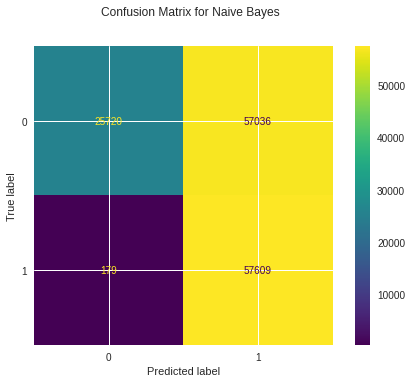

Classification report for classifier Naive Bayes:
              precision    recall  f1-score   support

           0       0.99      0.31      0.47     82756
           1       0.50      1.00      0.67     57788

    accuracy                           0.59    140544
   macro avg       0.75      0.65      0.57    140544
weighted avg       0.79      0.59      0.55    140544


ROC-AUC for classifier GaussianNB() 
 


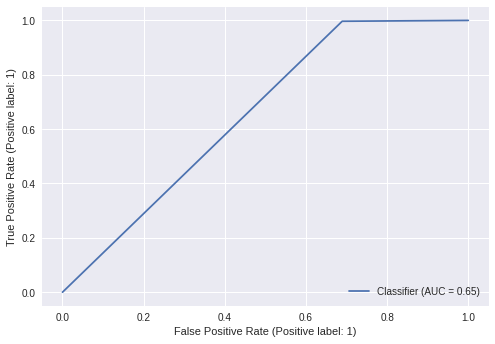

Classifier Logistic Regression took 0.15617021666666667 mins


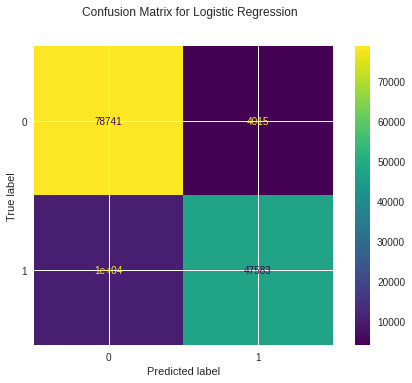

Classification report for classifier Logistic Regression:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92     82756
           1       0.92      0.82      0.87     57788

    accuracy                           0.90    140544
   macro avg       0.90      0.89      0.89    140544
weighted avg       0.90      0.90      0.90    140544


ROC-AUC for classifier LogisticRegression(random_state=42) 
 


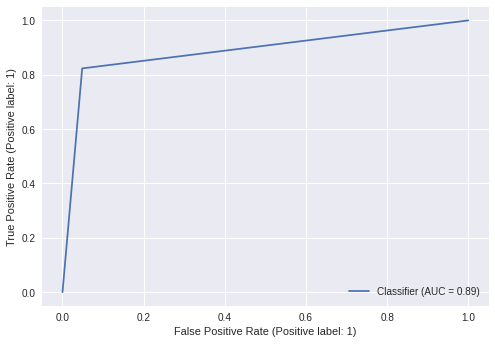

Classifier SVM took 0.21929610000000002 mins


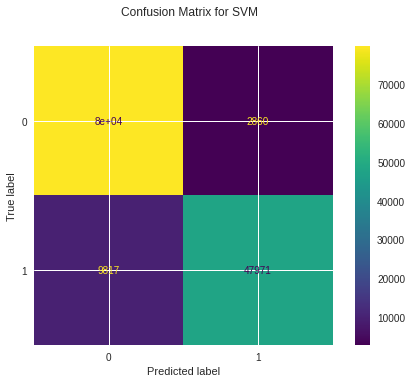

Classification report for classifier SVM:
              precision    recall  f1-score   support

           0       0.89      0.97      0.93     82756
           1       0.94      0.83      0.88     57788

    accuracy                           0.91    140544
   macro avg       0.92      0.90      0.90    140544
weighted avg       0.91      0.91      0.91    140544


ROC-AUC for classifier LinearSVC(random_state=42, tol=1e-05) 
 


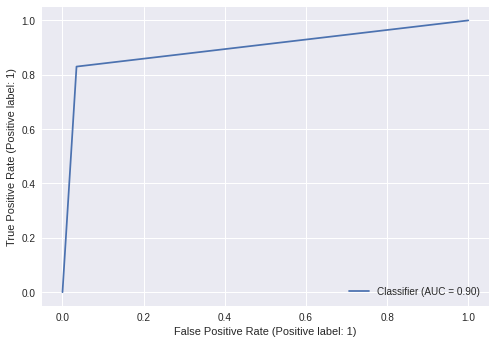

Classifier Decison Tree took 0.023170133333333336 mins


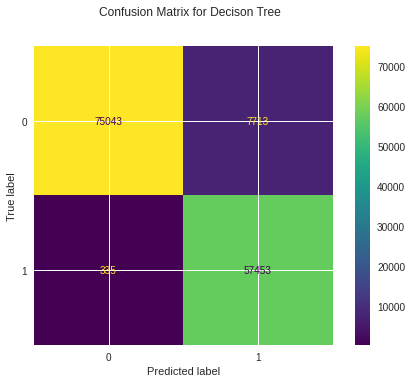

Classification report for classifier Decison Tree:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     82756
           1       0.88      0.99      0.93     57788

    accuracy                           0.94    140544
   macro avg       0.94      0.95      0.94    140544
weighted avg       0.95      0.94      0.94    140544


ROC-AUC for classifier DecisionTreeClassifier() 
 


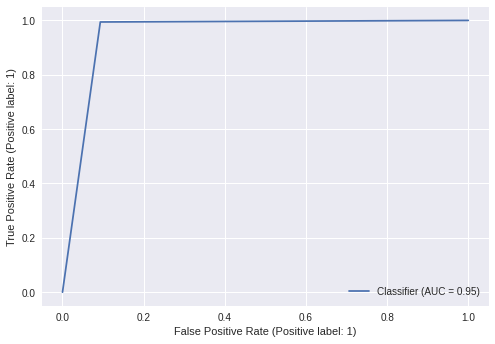

Classifier Random Forest took 0.7810169666666666 mins


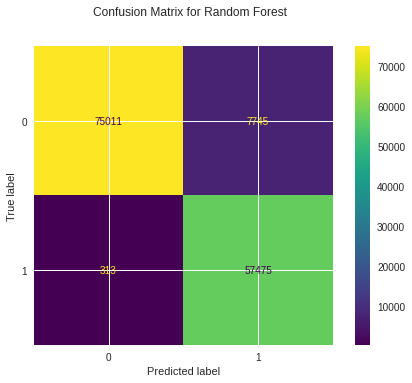

Classification report for classifier Random Forest:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     82756
           1       0.88      0.99      0.93     57788

    accuracy                           0.94    140544
   macro avg       0.94      0.95      0.94    140544
weighted avg       0.95      0.94      0.94    140544


ROC-AUC for classifier RandomForestClassifier(random_state=42) 
 


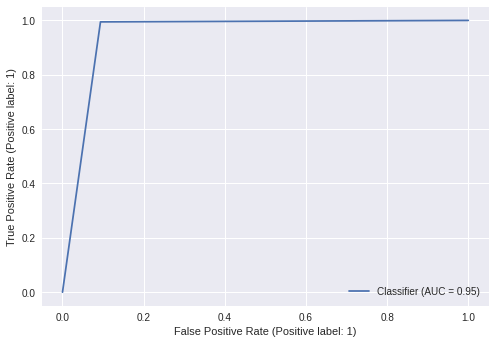

Classifier XGBoost took 0.5316896666666666 mins


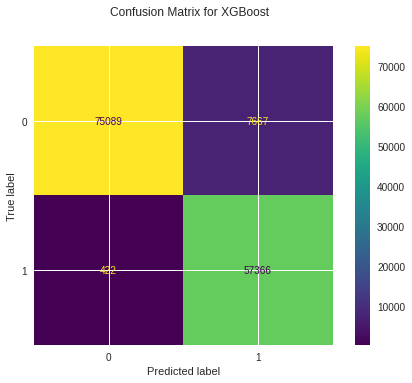

Classification report for classifier XGBoost:
              precision    recall  f1-score   support

           0       0.99      0.91      0.95     82756
           1       0.88      0.99      0.93     57788

    accuracy                           0.94    140544
   macro avg       0.94      0.95      0.94    140544
weighted avg       0.95      0.94      0.94    140544


ROC-AUC for classifier XGBClassifier(random_state=42) 
 


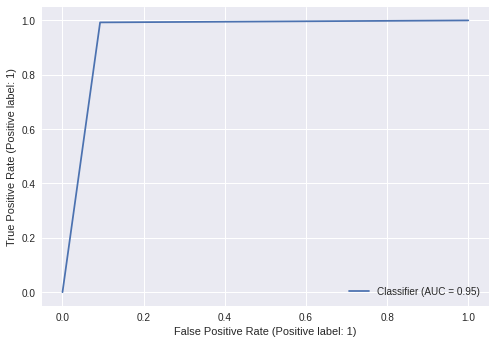

Classifier Voting Classifier took 0.92413975 mins


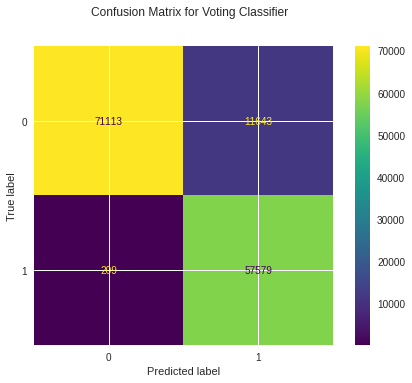

Classification report for classifier Voting Classifier:
              precision    recall  f1-score   support

           0       1.00      0.86      0.92     82756
           1       0.83      1.00      0.91     57788

    accuracy                           0.92    140544
   macro avg       0.91      0.93      0.91    140544
weighted avg       0.93      0.92      0.92    140544


ROC-AUC for classifier VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('gnb', GaussianNB())]) 
 


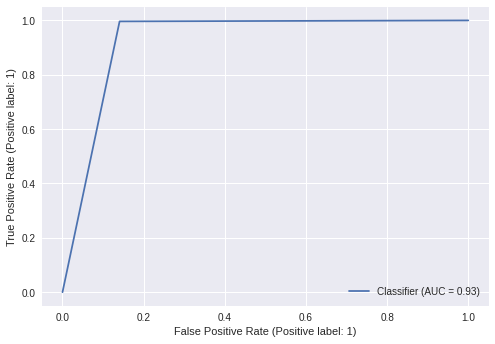

Classifier AdaBoost took 0.3824867 mins


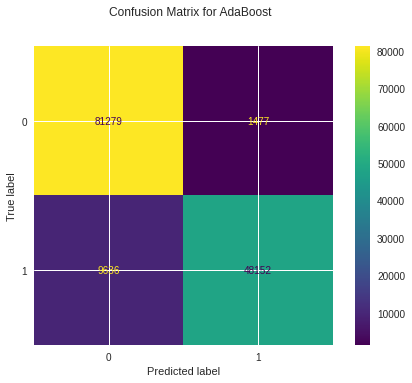

Classification report for classifier AdaBoost:
              precision    recall  f1-score   support

           0       0.89      0.98      0.94     82756
           1       0.97      0.83      0.90     57788

    accuracy                           0.92    140544
   macro avg       0.93      0.91      0.92    140544
weighted avg       0.93      0.92      0.92    140544


ROC-AUC for classifier AdaBoostClassifier() 
 


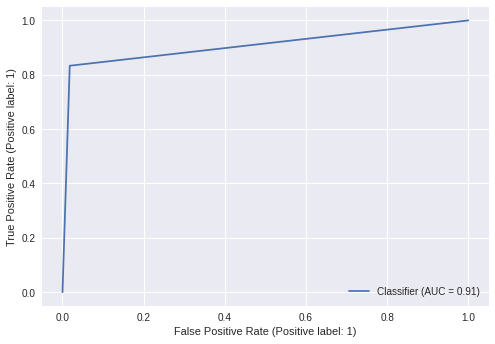

Classifier MLP took 10.0786073 mins


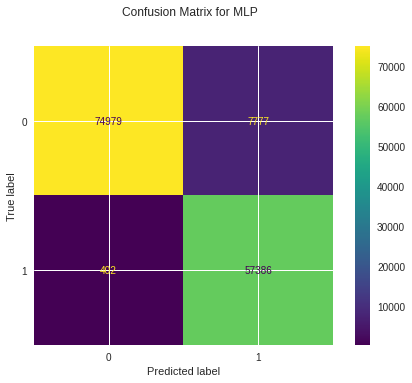

Classification report for classifier MLP:
              precision    recall  f1-score   support

           0       0.99      0.91      0.95     82756
           1       0.88      0.99      0.93     57788

    accuracy                           0.94    140544
   macro avg       0.94      0.95      0.94    140544
weighted avg       0.95      0.94      0.94    140544


ROC-AUC for classifier MLPClassifier() 
 


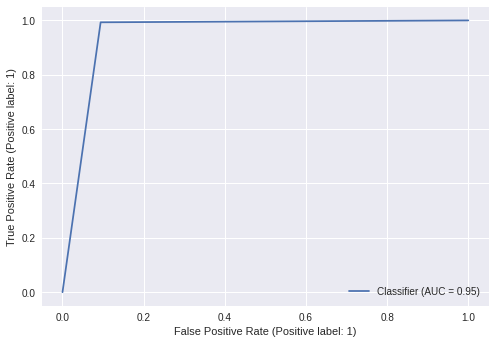

Classifier Naive Bayes took 0.004613516666666666 mins


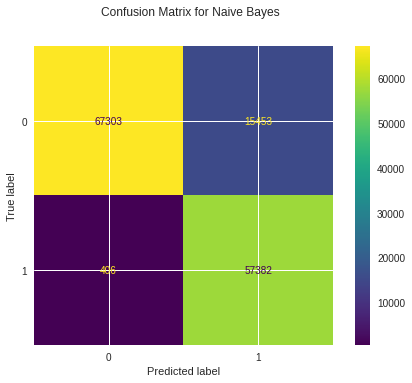

Classification report for classifier Naive Bayes:
              precision    recall  f1-score   support

           0       0.99      0.81      0.89     82756
           1       0.79      0.99      0.88     57788

    accuracy                           0.89    140544
   macro avg       0.89      0.90      0.89    140544
weighted avg       0.91      0.89      0.89    140544


ROC-AUC for classifier GaussianNB() 
 


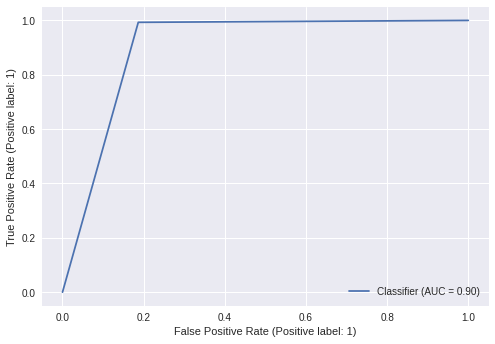

Classifier Logistic Regression took 0.18573951666666666 mins


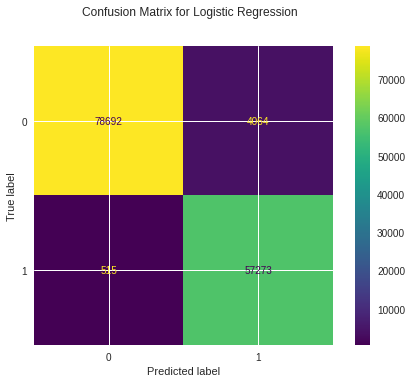

Classification report for classifier Logistic Regression:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97     82756
           1       0.93      0.99      0.96     57788

    accuracy                           0.97    140544
   macro avg       0.96      0.97      0.97    140544
weighted avg       0.97      0.97      0.97    140544


ROC-AUC for classifier LogisticRegression(random_state=42) 
 


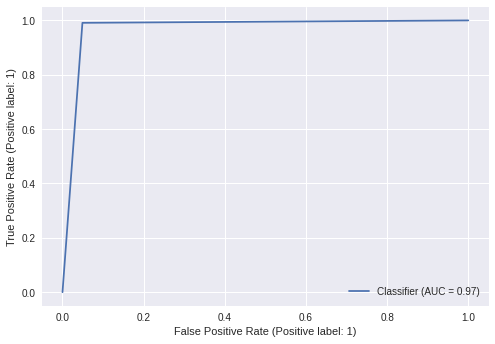

Classifier SVM took 0.3832855 mins


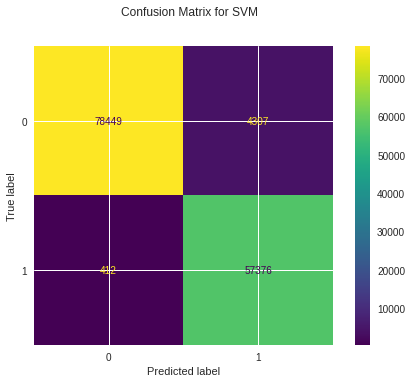

Classification report for classifier SVM:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97     82756
           1       0.93      0.99      0.96     57788

    accuracy                           0.97    140544
   macro avg       0.96      0.97      0.97    140544
weighted avg       0.97      0.97      0.97    140544


ROC-AUC for classifier LinearSVC(random_state=42, tol=1e-05) 
 


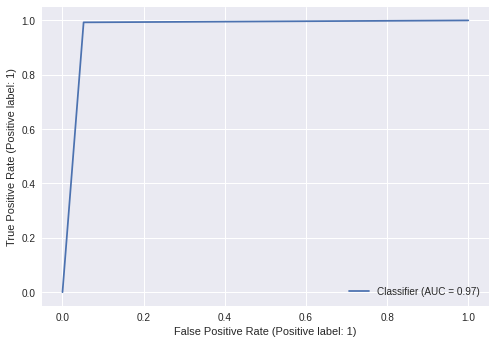

Classifier Decison Tree took 0.11102123333333333 mins


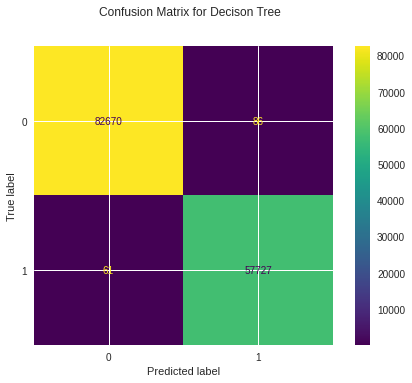

Classification report for classifier Decison Tree:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     82756
           1       1.00      1.00      1.00     57788

    accuracy                           1.00    140544
   macro avg       1.00      1.00      1.00    140544
weighted avg       1.00      1.00      1.00    140544


ROC-AUC for classifier DecisionTreeClassifier() 
 


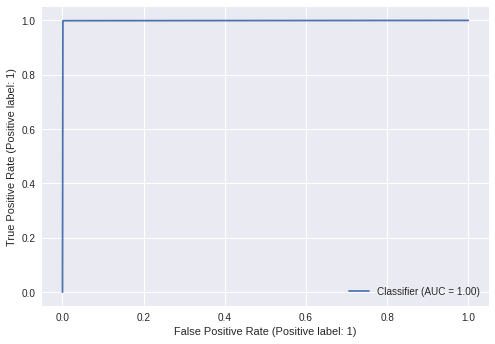

Classifier Random Forest took 1.4602433166666666 mins


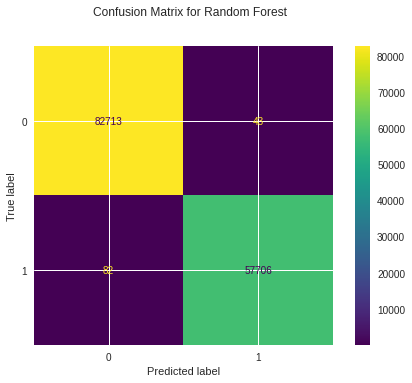

Classification report for classifier Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     82756
           1       1.00      1.00      1.00     57788

    accuracy                           1.00    140544
   macro avg       1.00      1.00      1.00    140544
weighted avg       1.00      1.00      1.00    140544


ROC-AUC for classifier RandomForestClassifier(random_state=42) 
 


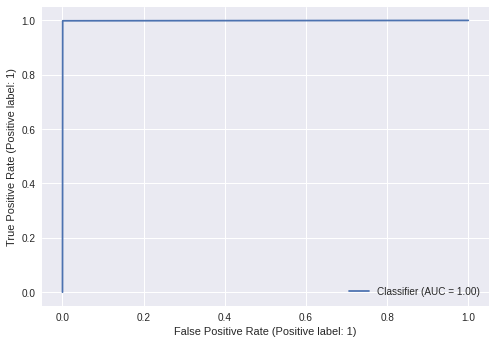

Classifier XGBoost took 1.0991501166666666 mins


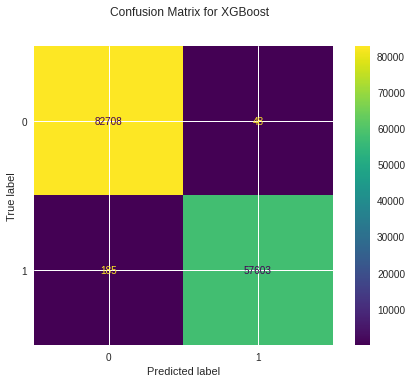

Classification report for classifier XGBoost:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     82756
           1       1.00      1.00      1.00     57788

    accuracy                           1.00    140544
   macro avg       1.00      1.00      1.00    140544
weighted avg       1.00      1.00      1.00    140544


ROC-AUC for classifier XGBClassifier(random_state=42) 
 


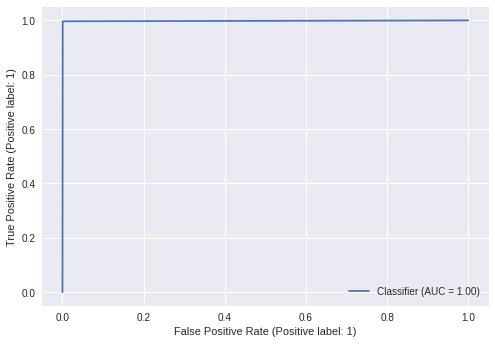

Classifier Voting Classifier took 1.7089274 mins


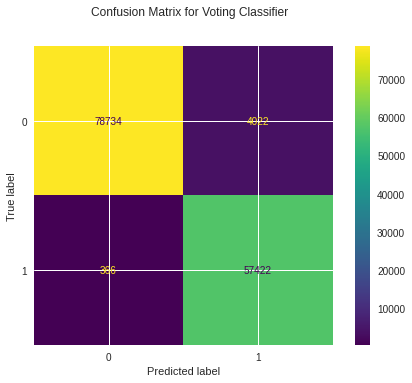

Classification report for classifier Voting Classifier:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     82756
           1       0.93      0.99      0.96     57788

    accuracy                           0.97    140544
   macro avg       0.96      0.97      0.97    140544
weighted avg       0.97      0.97      0.97    140544


ROC-AUC for classifier VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('gnb', GaussianNB())]) 
 


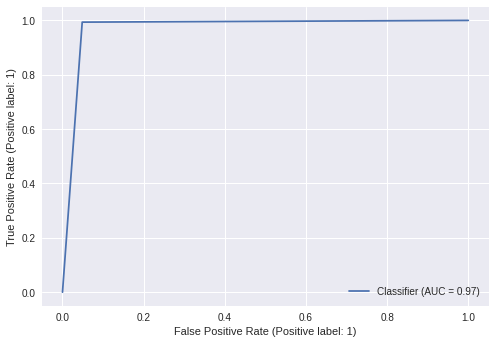

Classifier AdaBoost took 1.0021556666666667 mins


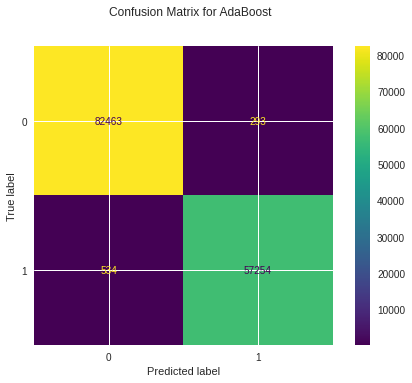

Classification report for classifier AdaBoost:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     82756
           1       0.99      0.99      0.99     57788

    accuracy                           0.99    140544
   macro avg       0.99      0.99      0.99    140544
weighted avg       0.99      0.99      0.99    140544


ROC-AUC for classifier AdaBoostClassifier() 
 


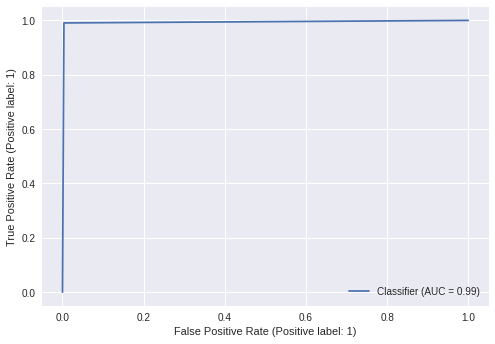

Classifier MLP took 4.509900200000001 mins


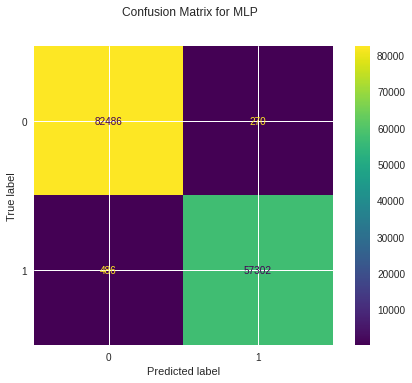

Classification report for classifier MLP:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     82756
           1       1.00      0.99      0.99     57788

    accuracy                           0.99    140544
   macro avg       0.99      0.99      0.99    140544
weighted avg       0.99      0.99      0.99    140544


ROC-AUC for classifier MLPClassifier() 
 


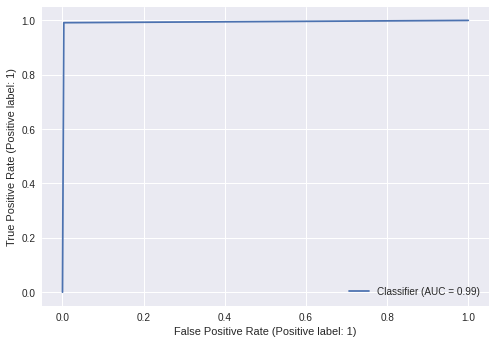

Classifier Naive Bayes took 0.013202166666666666 mins


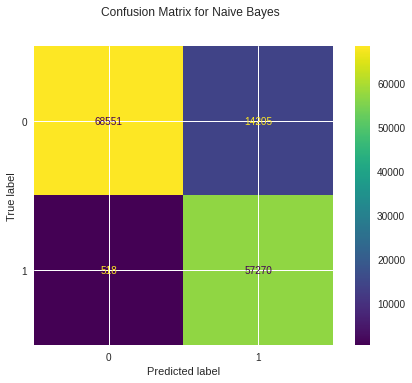

Classification report for classifier Naive Bayes:
              precision    recall  f1-score   support

           0       0.99      0.83      0.90     82756
           1       0.80      0.99      0.89     57788

    accuracy                           0.90    140544
   macro avg       0.90      0.91      0.89    140544
weighted avg       0.91      0.90      0.90    140544


ROC-AUC for classifier GaussianNB() 
 


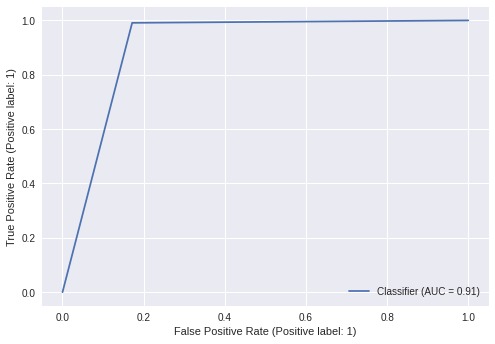

Classifier Logistic Regression took 0.22787735 mins


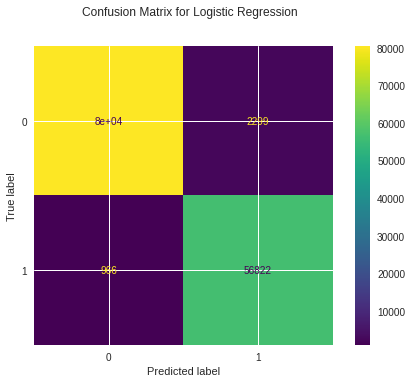

Classification report for classifier Logistic Regression:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     82756
           1       0.96      0.98      0.97     57788

    accuracy                           0.98    140544
   macro avg       0.97      0.98      0.98    140544
weighted avg       0.98      0.98      0.98    140544


ROC-AUC for classifier LogisticRegression(random_state=42) 
 


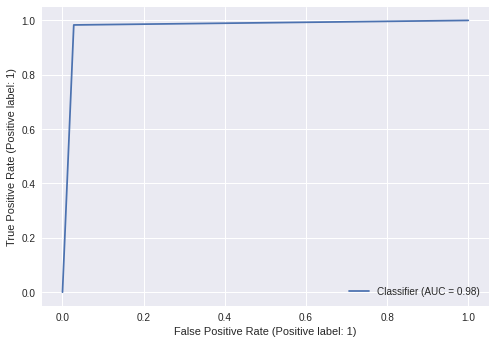

Classifier SVM took 0.52956155 mins


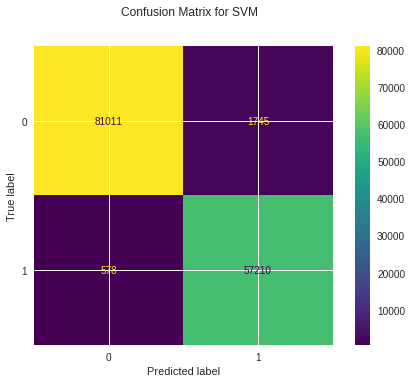

Classification report for classifier SVM:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     82756
           1       0.97      0.99      0.98     57788

    accuracy                           0.98    140544
   macro avg       0.98      0.98      0.98    140544
weighted avg       0.98      0.98      0.98    140544


ROC-AUC for classifier LinearSVC(random_state=42, tol=1e-05) 
 


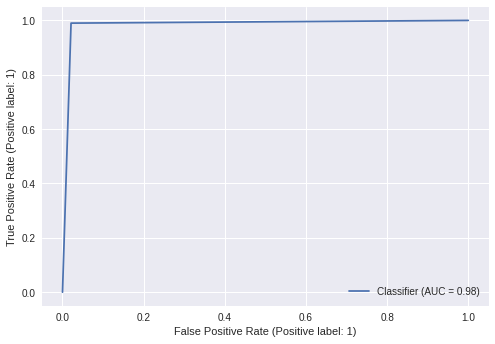

Classifier Decison Tree took 0.21532125000000002 mins


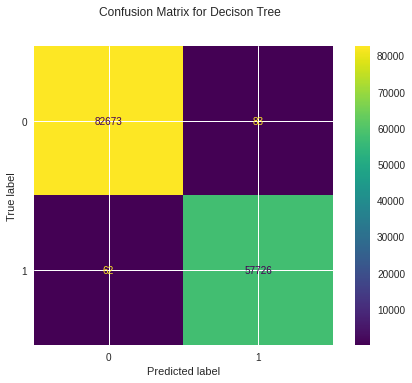

Classification report for classifier Decison Tree:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     82756
           1       1.00      1.00      1.00     57788

    accuracy                           1.00    140544
   macro avg       1.00      1.00      1.00    140544
weighted avg       1.00      1.00      1.00    140544


ROC-AUC for classifier DecisionTreeClassifier() 
 


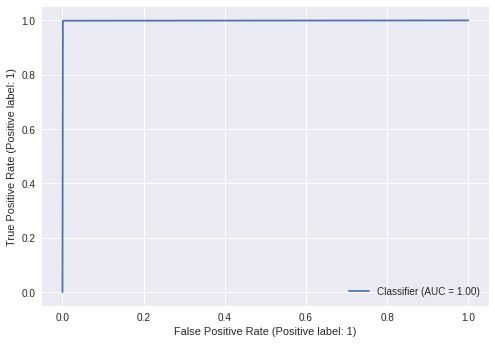

Classifier Random Forest took 1.7516668166666667 mins


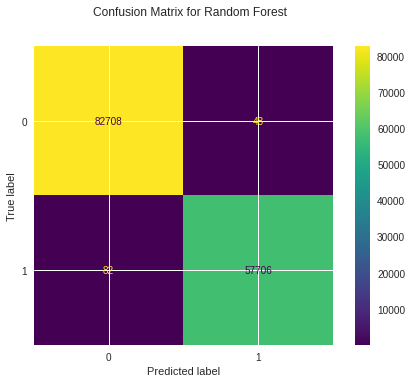

Classification report for classifier Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     82756
           1       1.00      1.00      1.00     57788

    accuracy                           1.00    140544
   macro avg       1.00      1.00      1.00    140544
weighted avg       1.00      1.00      1.00    140544


ROC-AUC for classifier RandomForestClassifier(random_state=42) 
 


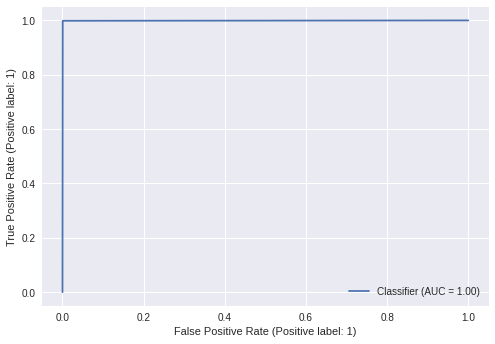

Classifier XGBoost took 1.7233642666666666 mins


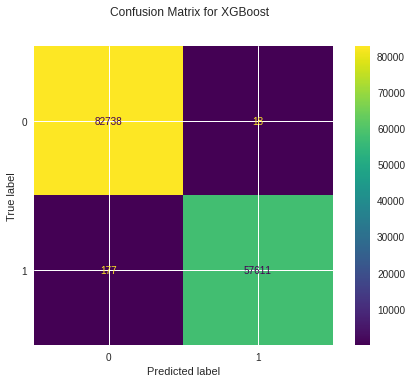

Classification report for classifier XGBoost:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     82756
           1       1.00      1.00      1.00     57788

    accuracy                           1.00    140544
   macro avg       1.00      1.00      1.00    140544
weighted avg       1.00      1.00      1.00    140544


ROC-AUC for classifier XGBClassifier(random_state=42) 
 


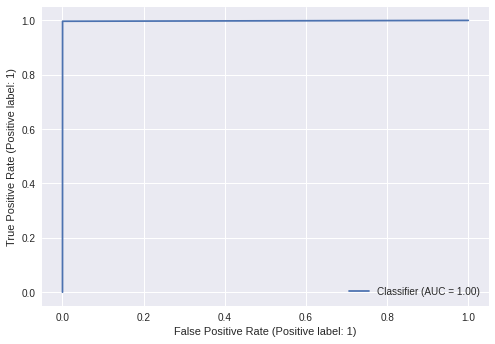

Classifier Voting Classifier took 2.071084066666667 mins


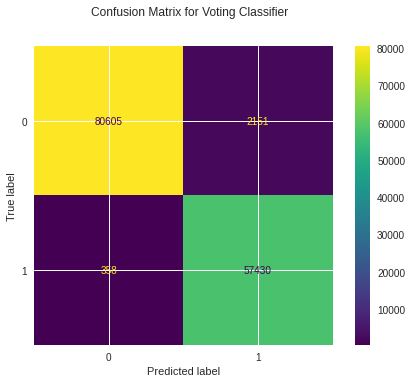

Classification report for classifier Voting Classifier:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     82756
           1       0.96      0.99      0.98     57788

    accuracy                           0.98    140544
   macro avg       0.98      0.98      0.98    140544
weighted avg       0.98      0.98      0.98    140544


ROC-AUC for classifier VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('gnb', GaussianNB())]) 
 


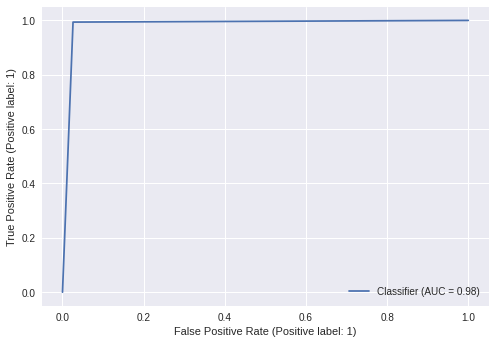

Classifier AdaBoost took 1.3952358666666667 mins


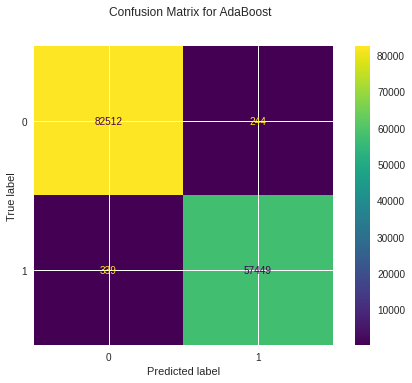

Classification report for classifier AdaBoost:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     82756
           1       1.00      0.99      0.99     57788

    accuracy                           1.00    140544
   macro avg       1.00      1.00      1.00    140544
weighted avg       1.00      1.00      1.00    140544


ROC-AUC for classifier AdaBoostClassifier() 
 


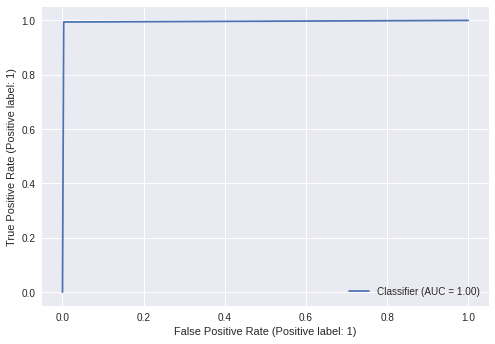

Classifier MLP took 3.8487182499999997 mins


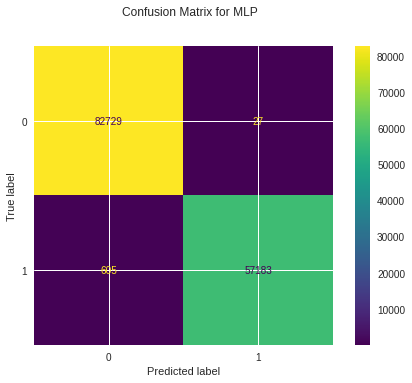

Classification report for classifier MLP:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     82756
           1       1.00      0.99      0.99     57788

    accuracy                           1.00    140544
   macro avg       1.00      0.99      1.00    140544
weighted avg       1.00      1.00      1.00    140544


ROC-AUC for classifier MLPClassifier() 
 


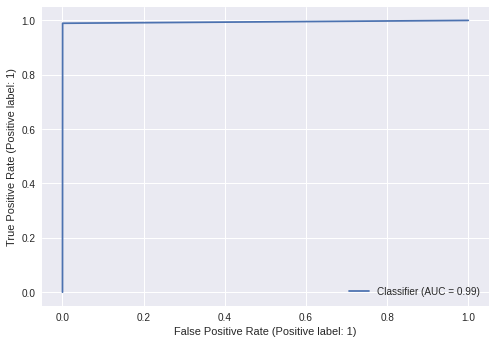

Classifier Naive Bayes took 0.004214933333333334 mins


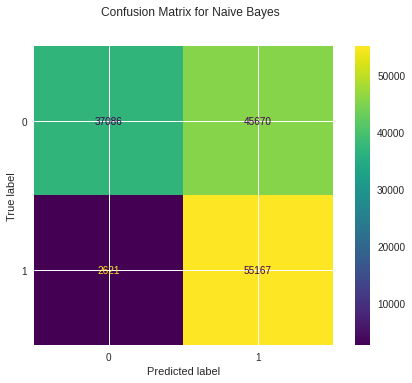

Classification report for classifier Naive Bayes:
              precision    recall  f1-score   support

           0       0.93      0.45      0.61     82756
           1       0.55      0.95      0.70     57788

    accuracy                           0.66    140544
   macro avg       0.74      0.70      0.65    140544
weighted avg       0.77      0.66      0.64    140544


ROC-AUC for classifier GaussianNB() 
 


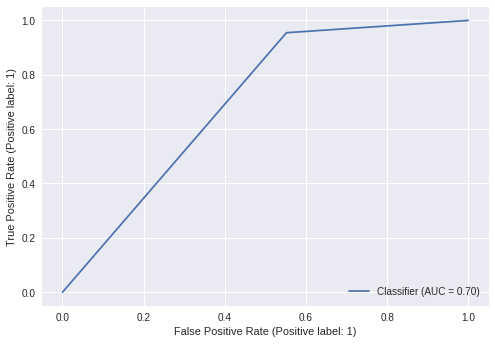

Classifier Logistic Regression took 0.16103046666666668 mins


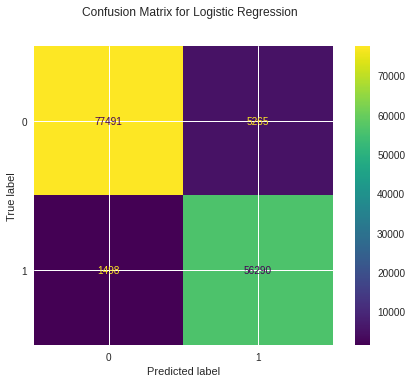

Classification report for classifier Logistic Regression:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96     82756
           1       0.91      0.97      0.94     57788

    accuracy                           0.95    140544
   macro avg       0.95      0.96      0.95    140544
weighted avg       0.95      0.95      0.95    140544


ROC-AUC for classifier LogisticRegression(random_state=42) 
 


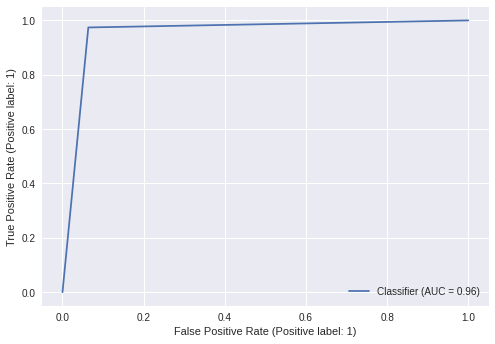

Classifier SVM took 0.7395566833333334 mins


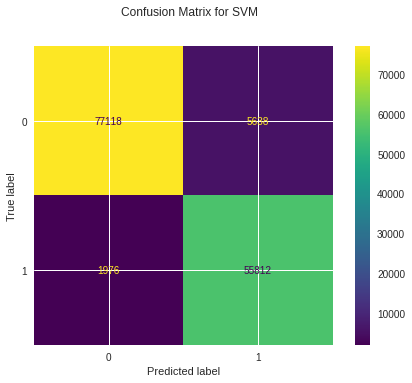

Classification report for classifier SVM:
              precision    recall  f1-score   support

           0       0.98      0.93      0.95     82756
           1       0.91      0.97      0.94     57788

    accuracy                           0.95    140544
   macro avg       0.94      0.95      0.94    140544
weighted avg       0.95      0.95      0.95    140544


ROC-AUC for classifier LinearSVC(random_state=42, tol=1e-05) 
 


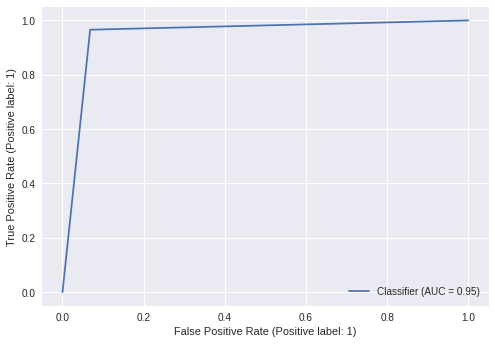

Classifier Decison Tree took 0.6384467166666667 mins


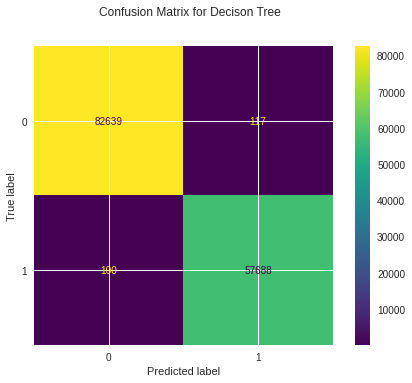

Classification report for classifier Decison Tree:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     82756
           1       1.00      1.00      1.00     57788

    accuracy                           1.00    140544
   macro avg       1.00      1.00      1.00    140544
weighted avg       1.00      1.00      1.00    140544


ROC-AUC for classifier DecisionTreeClassifier() 
 


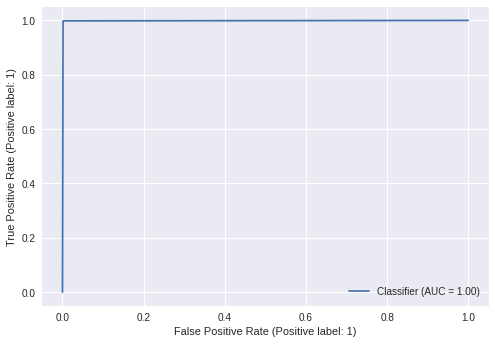

Classifier Random Forest took 5.156125916666666 mins


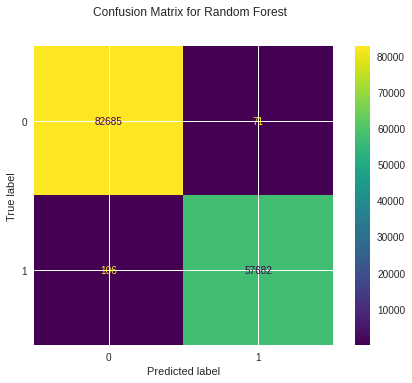

Classification report for classifier Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     82756
           1       1.00      1.00      1.00     57788

    accuracy                           1.00    140544
   macro avg       1.00      1.00      1.00    140544
weighted avg       1.00      1.00      1.00    140544


ROC-AUC for classifier RandomForestClassifier(random_state=42) 
 


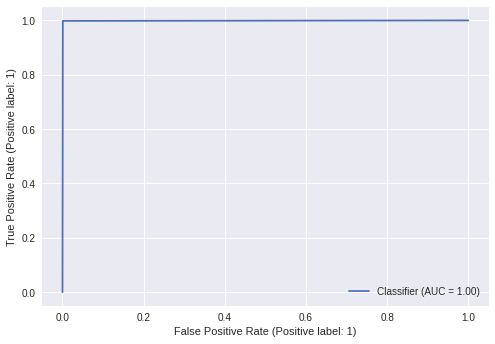

Classifier XGBoost took 1.7147273666666665 mins


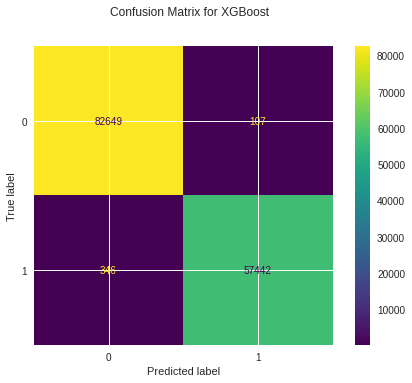

Classification report for classifier XGBoost:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     82756
           1       1.00      0.99      1.00     57788

    accuracy                           1.00    140544
   macro avg       1.00      1.00      1.00    140544
weighted avg       1.00      1.00      1.00    140544


ROC-AUC for classifier XGBClassifier(random_state=42) 
 


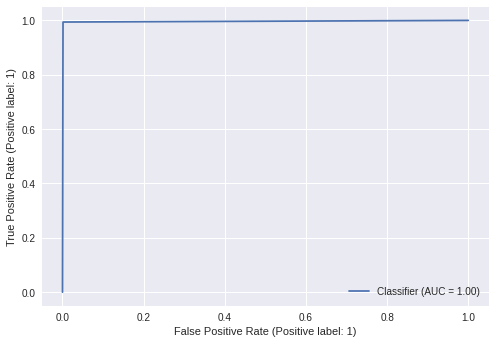

Classifier Voting Classifier took 5.3186662 mins


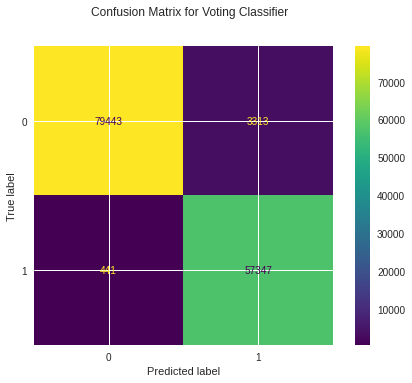

Classification report for classifier Voting Classifier:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98     82756
           1       0.95      0.99      0.97     57788

    accuracy                           0.97    140544
   macro avg       0.97      0.98      0.97    140544
weighted avg       0.97      0.97      0.97    140544


ROC-AUC for classifier VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('gnb', GaussianNB())]) 
 


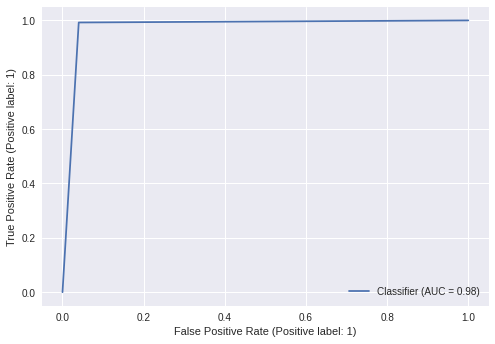

Classifier AdaBoost took 1.9557604333333332 mins


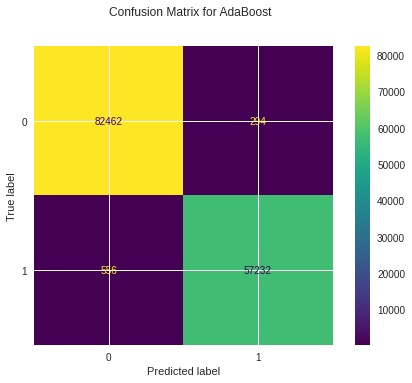

Classification report for classifier AdaBoost:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     82756
           1       0.99      0.99      0.99     57788

    accuracy                           0.99    140544
   macro avg       0.99      0.99      0.99    140544
weighted avg       0.99      0.99      0.99    140544


ROC-AUC for classifier AdaBoostClassifier() 
 


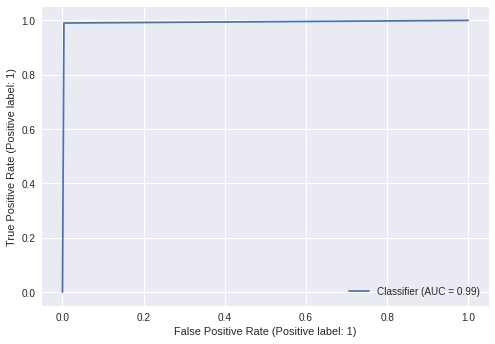

Classifier MLP took 3.520040883333333 mins


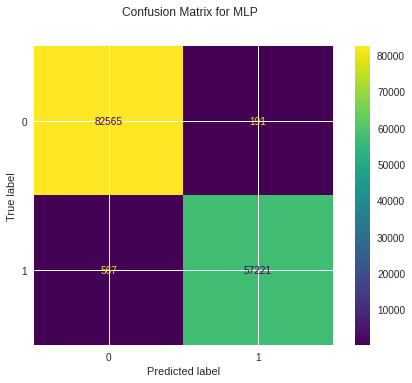

Classification report for classifier MLP:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     82756
           1       1.00      0.99      0.99     57788

    accuracy                           0.99    140544
   macro avg       0.99      0.99      0.99    140544
weighted avg       0.99      0.99      0.99    140544


ROC-AUC for classifier MLPClassifier() 
 


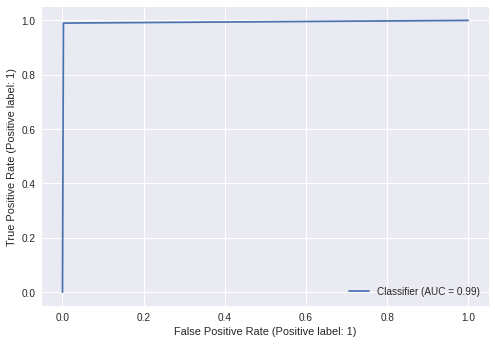

In [10]:
#CICIDS17 Dataset

# from google.colab import drive
# drive.mount('/content/gdrive')

df1=pd.read_csv('/content/gdrive/MyDrive/IDS Asignment Datasets/cicids2017/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')
df2=pd.read_csv('/content/gdrive/MyDrive/IDS Asignment Datasets/cicids2017/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv')
df3 = pd.read_csv('/content/gdrive/MyDrive/IDS Asignment Datasets/cicids2017/Friday-WorkingHours-Morning.pcap_ISCX.csv')

logger = open('log.csv','a')
print("log_id","ConfusionMatrix","RunTime (mins)",sep=',',flush=True,file=logger)

# df1=pd.read_csv('../IDS Asignment Datasets/cicids2017/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')
# df2=pd.read_csv('../IDS Asignment Datasets/cicids2017/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv')
# df3 = pd.read_csv('../IDS Asignment Datasets/cicids2017/Friday-WorkingHours-Morning.pcap_ISCX.csv')

# Concatenation of dataframes
df = pd.concat([df1,df2])
del df1,df2
df = pd.concat([df,df3])
del df3
# desc = profile(df)
l = dict(df.isna().sum())
filtered_dict = {k:v for (k,v) in l.items() if v >0}
print('Nan values are there in columns: ',filtered_dict)

# As Flow Bytes/s has 480 infinite values, 47 missing values filtering those rows out

df = df[~df.isin([np.nan, np.inf, -np.inf]).any(1)] #slicing dataframe

# Removing these columns as their value counts are zero (can be seen from profile). Not remove destination port
# as it may influence the attack (eg: HTTP attacks are on port 80)
cols_to_remove = [' Bwd PSH Flags',' Bwd URG Flags','Fwd Avg Bytes/Bulk',' Fwd Avg Packets/Bulk',' Fwd Avg Bulk Rate',
                   ' Bwd Avg Bytes/Bulk',' Bwd Avg Packets/Bulk','Bwd Avg Bulk Rate']
df.drop(columns=cols_to_remove,inplace=True)
df,y = encoding(df)
# changing dataset to binary classification dataset
y.loc[y[' Label'] > 0, ' Label'] = 1
print('Value counts ',y.value_counts())
new_datasets = create_dataset(df,y)
pca_data = PCA(n_components=20).fit_transform(df.values,y)
pca_data = pd.DataFrame(data= pca_data)
new_datasets.append( (pca_data,y ))
print('modified pca data shape: ',pca_data.shape)
(run_times,confusion_matrices,roc_aucs,cf_figures) = log_metrics(new_datasets,logger)
imbalanced_classification(new_datasets,logger)

In [17]:
logger.close()

log = pd.read_csv('log.csv')
log[['tp','fn','fp','tn']]=log['ConfusionMatrix'].str.split('\s+', expand = True)
log[['tp','fn','fp','tn']] = log[['tp','fn','fp','tn']].apply(pd.to_numeric,errors='coerce')
log['accuracy']=log.apply(lambda row: (row.tp+row.tn)/(row.tp+row.fp+row.tn+row.fn), axis=1)
log['precision']=log.apply(lambda row: (row.tp)/(row.tp+row.fp), axis=1)
log['recall']=log.apply(lambda row: (row.tp)/(row.tp+row.fn), axis=1)
log['f1score']=log.apply(lambda row: (row.precision*row.recall*2)/(row.precision+row.recall), axis=1)
log.drop(['tp', 'fn','fp','tn'], axis = 1,inplace=True)


# logging the index of dataset+model pair highest metrics
print(log.query('precision==precision.max()'))
print(log.query('recall==recall.max()'))
print(log.query('f1score==f1score.max()'))
print(log.query('accuracy==accuracy.max()'))


    log_id           ConfusionMatrix  RunTime (mins)  accuracy  precision  \
12      12  82670    86     61 57727        0.111021  0.998954   0.999263   

      recall   f1score  
12  0.998961  0.999112  
    log_id           ConfusionMatrix  RunTime (mins)  accuracy  precision  \
23      23  82738    18    177 57611        1.723364  0.998613   0.997865   

      recall   f1score  
23  0.999782  0.998823  
    log_id           ConfusionMatrix  RunTime (mins)  accuracy  precision  \
13      13  82713    43     82 57706        1.460243  0.999111    0.99901   

     recall   f1score  
13  0.99948  0.999245  
    log_id           ConfusionMatrix  RunTime (mins)  accuracy  precision  \
13      13  82713    43     82 57706        1.460243  0.999111    0.99901   

     recall   f1score  
13  0.99948  0.999245  


In [13]:
# UNSW NB15 
schema = pd.read_csv('/content/gdrive/MyDrive/IDS Asignment Datasets/unsw-nb15/NUSW-NB15_features.csv',encoding='cp1252')
schema = np.array(schema.Name)

df1 = pd.read_csv('/content/gdrive/MyDrive/IDS Asignment Datasets/unsw-nb15/UNSW-NB15_3.csv',names=schema)
df2 = pd.read_csv('/content/gdrive/MyDrive/IDS Asignment Datasets/unsw-nb15/UNSW-NB15_4.csv',names=schema)

# df1 = pd.read_csv('../IDS Asignment Datasets/unsw-nb15/UNSW-NB15_3.csv',names=schema)
# df2 = pd.read_csv('../IDS Asignment Datasets/unsw-nb15/UNSW-NB15_4.csv',names=schema)

# Concatenation of dataframes
df = pd.concat([df1,df2])

del df1,df2

# desc = profile(df,name='UNSW-NB15')
l = dict(df.isna().sum())
filtered_dict = {k:v for (k,v) in l.items() if v >0}
print('Nan values are there in columns: ',filtered_dict)

# As Flow Bytes/s has 480 infinite values, 47 missing values filtering those rows out
cols_to_remove = ['ct_flw_http_mthd','is_ftp_login', 'attack_cat'] # removing these as there are >60% missing values 
df.drop(columns=cols_to_remove,inplace=True)


Nan values are there in columns:  {'ct_flw_http_mthd': 1062889, 'is_ftp_login': 1122841, 'attack_cat': 893726}


Value counts  Label
0        893726
1        246319
dtype: int64
Original dataset shape is: (1140045, 45)


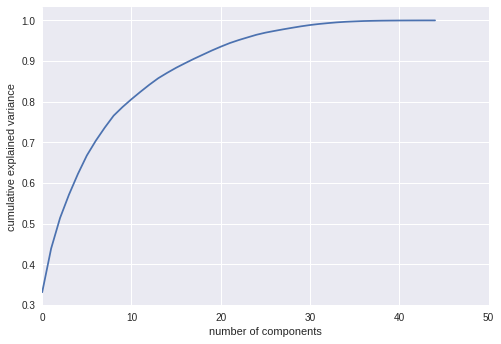

modified pca data shape:  (1140045, 40)
Classifier Naive Bayes took 0.005796966666666667 mins


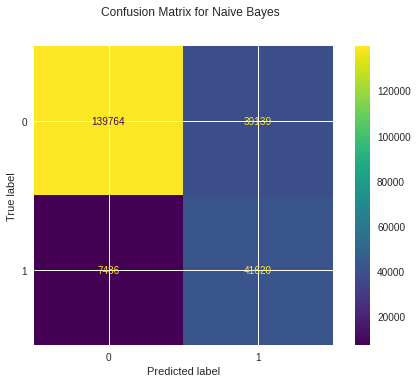

Classification report for classifier Naive Bayes:
              precision    recall  f1-score   support

           0       0.95      0.78      0.86    178903
           1       0.52      0.85      0.64     49106

    accuracy                           0.80    228009
   macro avg       0.73      0.81      0.75    228009
weighted avg       0.86      0.80      0.81    228009


ROC-AUC for classifier GaussianNB() 
 


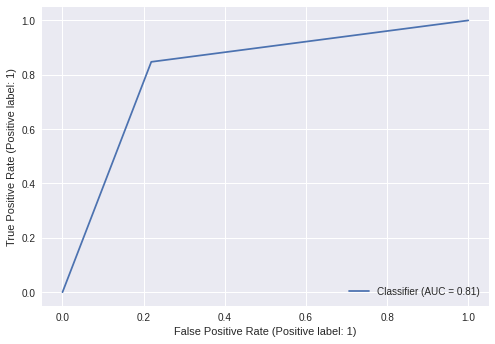

Classifier Logistic Regression took 0.24706745 mins


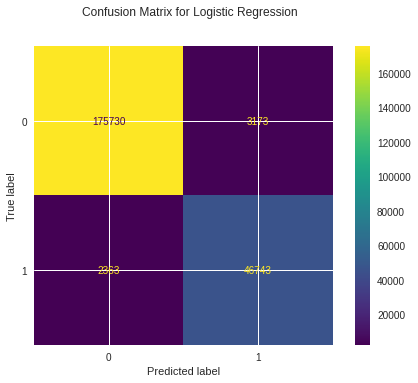

Classification report for classifier Logistic Regression:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98    178903
           1       0.94      0.95      0.94     49106

    accuracy                           0.98    228009
   macro avg       0.96      0.97      0.96    228009
weighted avg       0.98      0.98      0.98    228009


ROC-AUC for classifier LogisticRegression(random_state=42) 
 


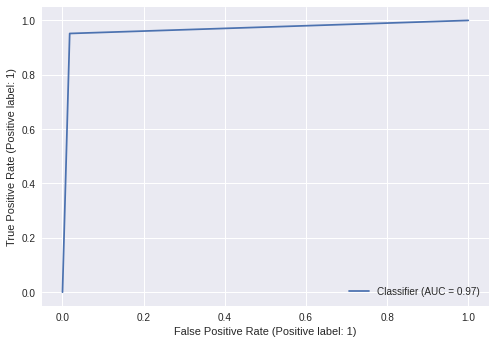

Classifier SVM took 0.43587675000000004 mins


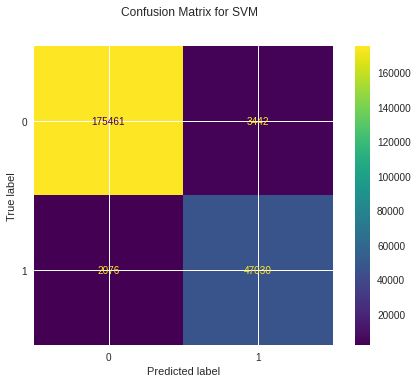

Classification report for classifier SVM:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98    178903
           1       0.93      0.96      0.94     49106

    accuracy                           0.98    228009
   macro avg       0.96      0.97      0.96    228009
weighted avg       0.98      0.98      0.98    228009


ROC-AUC for classifier LinearSVC(random_state=42, tol=1e-05) 
 


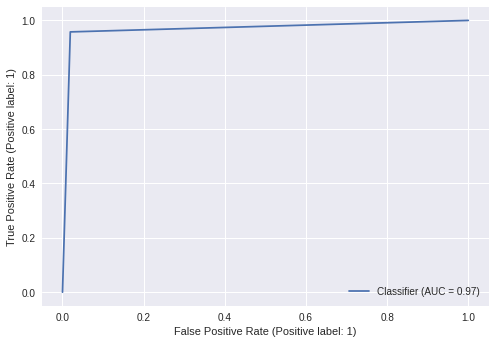

Classifier Decison Tree took 0.10262851666666667 mins


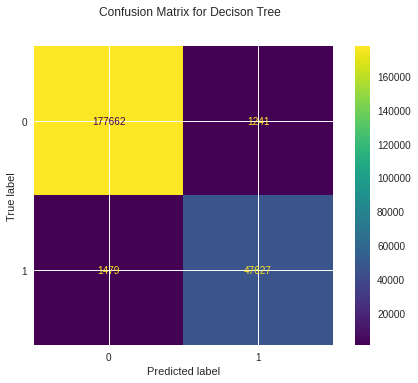

Classification report for classifier Decison Tree:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    178903
           1       0.97      0.97      0.97     49106

    accuracy                           0.99    228009
   macro avg       0.98      0.98      0.98    228009
weighted avg       0.99      0.99      0.99    228009


ROC-AUC for classifier DecisionTreeClassifier() 
 


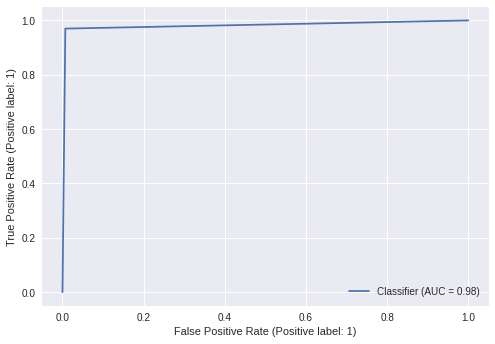

Classifier Random Forest took 1.7878704333333333 mins


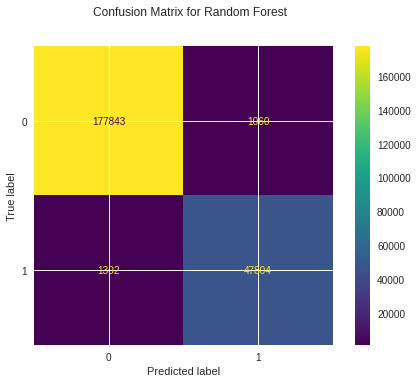

Classification report for classifier Random Forest:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    178903
           1       0.98      0.97      0.98     49106

    accuracy                           0.99    228009
   macro avg       0.99      0.98      0.98    228009
weighted avg       0.99      0.99      0.99    228009


ROC-AUC for classifier RandomForestClassifier(random_state=42) 
 


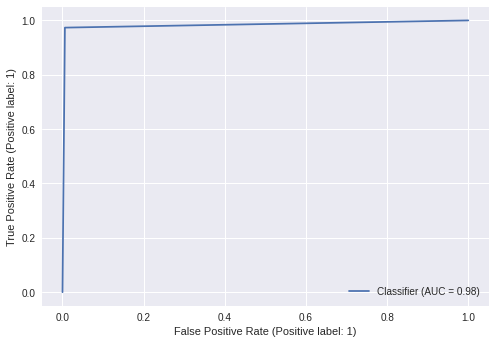

Classifier XGBoost took 1.1961992666666668 mins


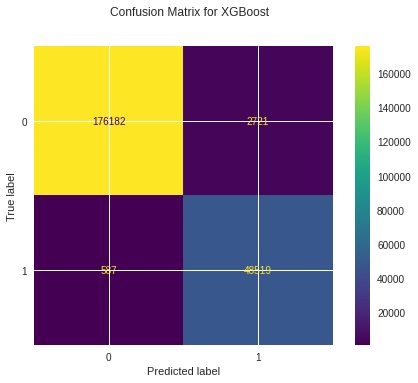

Classification report for classifier XGBoost:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    178903
           1       0.95      0.99      0.97     49106

    accuracy                           0.99    228009
   macro avg       0.97      0.99      0.98    228009
weighted avg       0.99      0.99      0.99    228009


ROC-AUC for classifier XGBClassifier(random_state=42) 
 


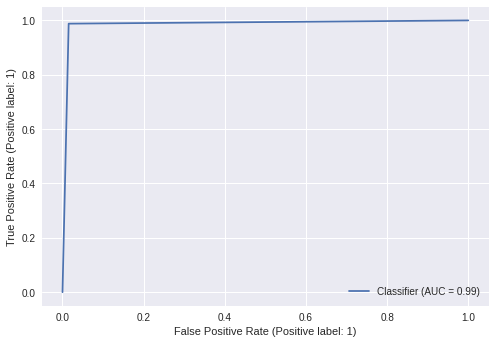

Classifier Voting Classifier took 1.8655387666666667 mins


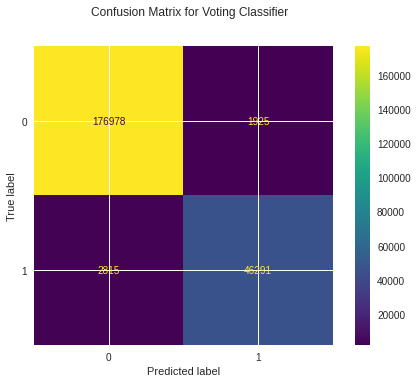

Classification report for classifier Voting Classifier:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99    178903
           1       0.96      0.94      0.95     49106

    accuracy                           0.98    228009
   macro avg       0.97      0.97      0.97    228009
weighted avg       0.98      0.98      0.98    228009


ROC-AUC for classifier VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('gnb', GaussianNB())]) 
 


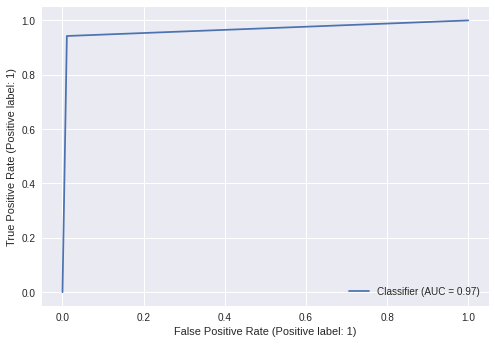

Classifier AdaBoost took 0.9560628666666666 mins


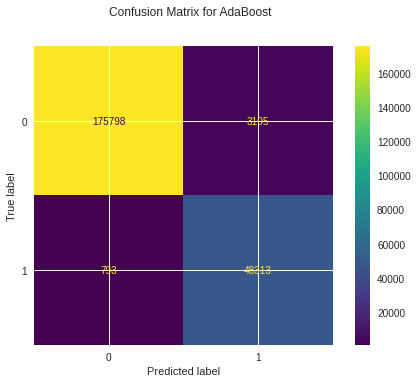

Classification report for classifier AdaBoost:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    178903
           1       0.94      0.98      0.96     49106

    accuracy                           0.98    228009
   macro avg       0.97      0.98      0.98    228009
weighted avg       0.98      0.98      0.98    228009


ROC-AUC for classifier AdaBoostClassifier() 
 


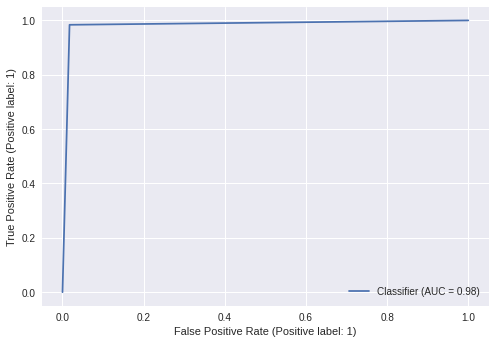

Classifier MLP took 9.882357566666666 mins


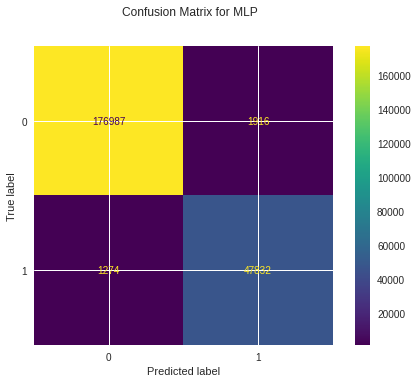

Classification report for classifier MLP:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    178903
           1       0.96      0.97      0.97     49106

    accuracy                           0.99    228009
   macro avg       0.98      0.98      0.98    228009
weighted avg       0.99      0.99      0.99    228009


ROC-AUC for classifier MLPClassifier() 
 


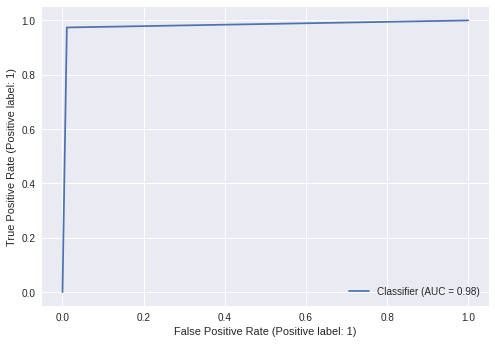

Classifier Naive Bayes took 0.0064708 mins


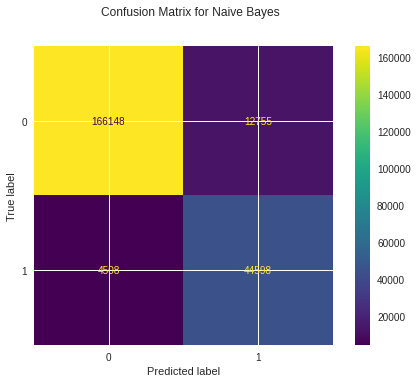

Classification report for classifier Naive Bayes:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95    178903
           1       0.78      0.91      0.84     49106

    accuracy                           0.92    228009
   macro avg       0.88      0.92      0.89    228009
weighted avg       0.93      0.92      0.93    228009


ROC-AUC for classifier GaussianNB() 
 


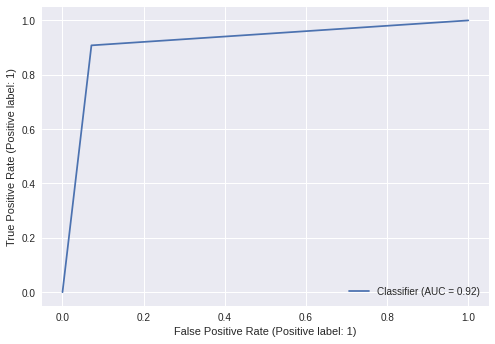

Classifier Logistic Regression took 0.26272565 mins


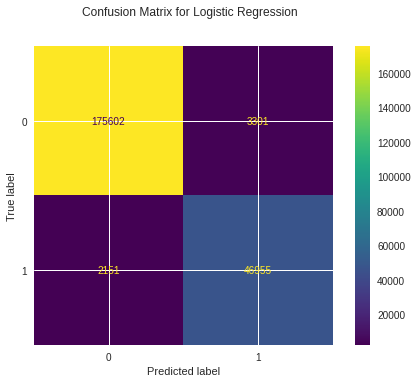

Classification report for classifier Logistic Regression:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98    178903
           1       0.93      0.96      0.95     49106

    accuracy                           0.98    228009
   macro avg       0.96      0.97      0.96    228009
weighted avg       0.98      0.98      0.98    228009


ROC-AUC for classifier LogisticRegression(random_state=42) 
 


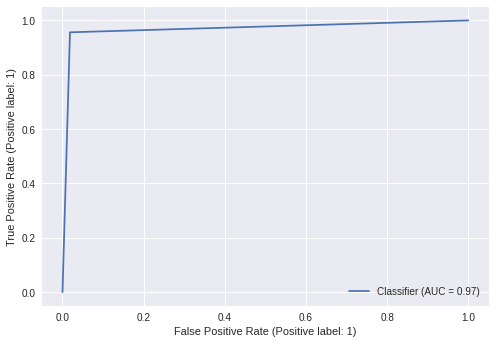

Classifier SVM took 0.6496146666666667 mins


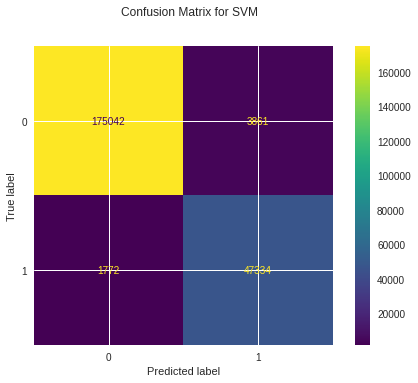

Classification report for classifier SVM:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98    178903
           1       0.92      0.96      0.94     49106

    accuracy                           0.98    228009
   macro avg       0.96      0.97      0.96    228009
weighted avg       0.98      0.98      0.98    228009


ROC-AUC for classifier LinearSVC(random_state=42, tol=1e-05) 
 


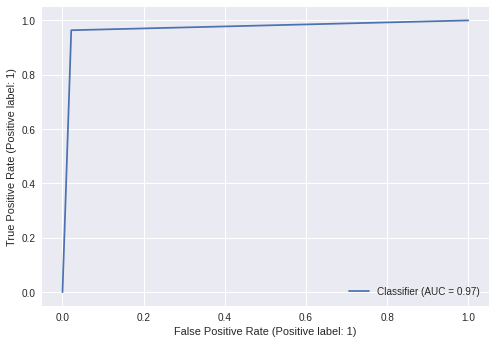

Classifier Decison Tree took 0.11947596666666667 mins


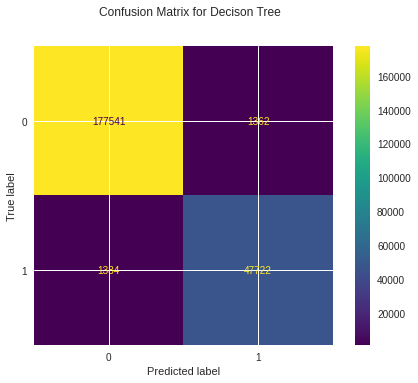

Classification report for classifier Decison Tree:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    178903
           1       0.97      0.97      0.97     49106

    accuracy                           0.99    228009
   macro avg       0.98      0.98      0.98    228009
weighted avg       0.99      0.99      0.99    228009


ROC-AUC for classifier DecisionTreeClassifier() 
 


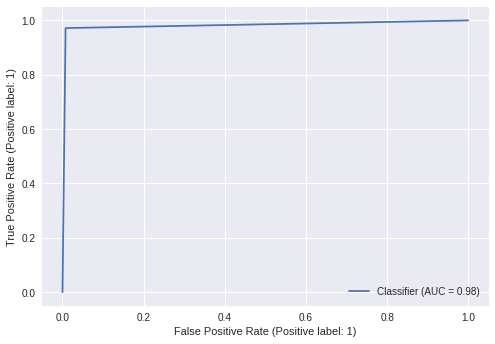

Classifier Random Forest took 2.1428353666666666 mins


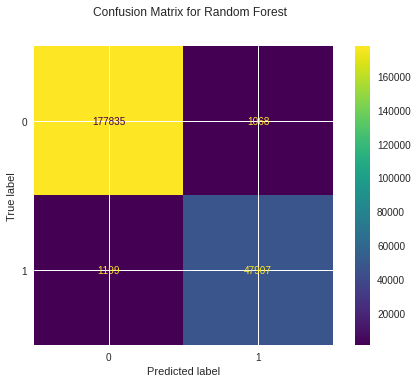

Classification report for classifier Random Forest:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    178903
           1       0.98      0.98      0.98     49106

    accuracy                           0.99    228009
   macro avg       0.99      0.98      0.99    228009
weighted avg       0.99      0.99      0.99    228009


ROC-AUC for classifier RandomForestClassifier(random_state=42) 
 


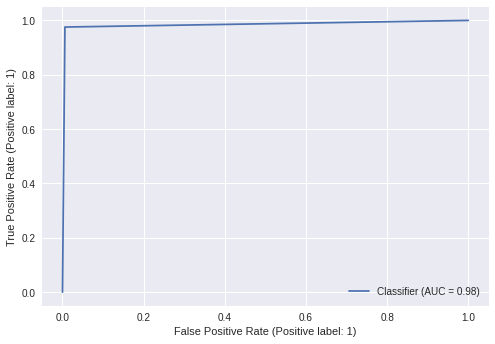

Classifier XGBoost took 1.7045980666666667 mins


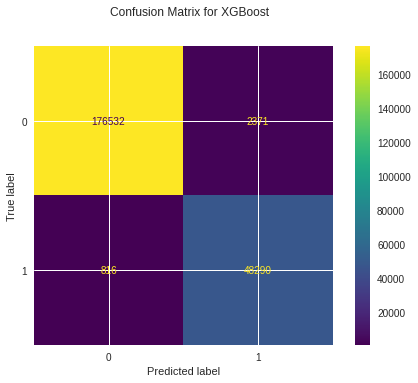

Classification report for classifier XGBoost:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    178903
           1       0.95      0.98      0.97     49106

    accuracy                           0.99    228009
   macro avg       0.97      0.99      0.98    228009
weighted avg       0.99      0.99      0.99    228009


ROC-AUC for classifier XGBClassifier(random_state=42) 
 


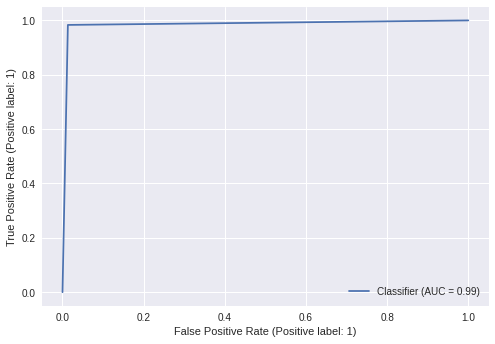

Classifier Voting Classifier took 2.569409333333333 mins


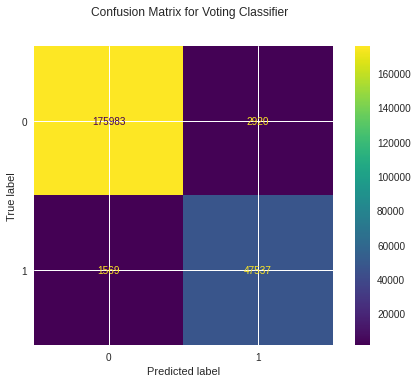

Classification report for classifier Voting Classifier:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99    178903
           1       0.94      0.97      0.95     49106

    accuracy                           0.98    228009
   macro avg       0.97      0.98      0.97    228009
weighted avg       0.98      0.98      0.98    228009


ROC-AUC for classifier VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('gnb', GaussianNB())]) 
 


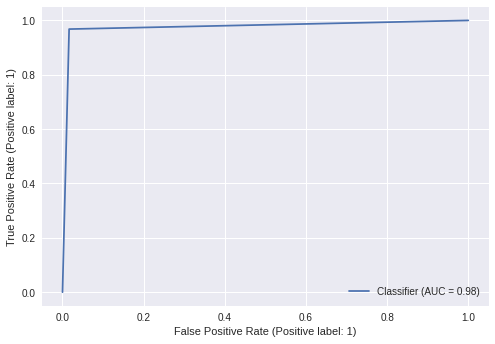

Classifier AdaBoost took 1.3703849499999998 mins


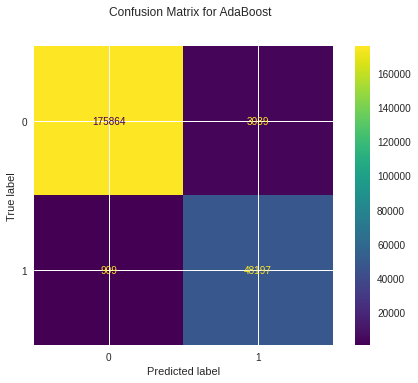

Classification report for classifier AdaBoost:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99    178903
           1       0.94      0.98      0.96     49106

    accuracy                           0.98    228009
   macro avg       0.97      0.98      0.97    228009
weighted avg       0.98      0.98      0.98    228009


ROC-AUC for classifier AdaBoostClassifier() 
 


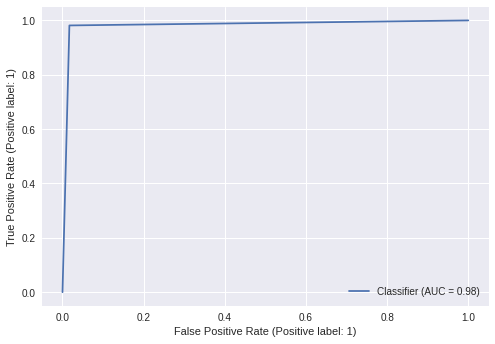

Classifier MLP took 3.7459997 mins


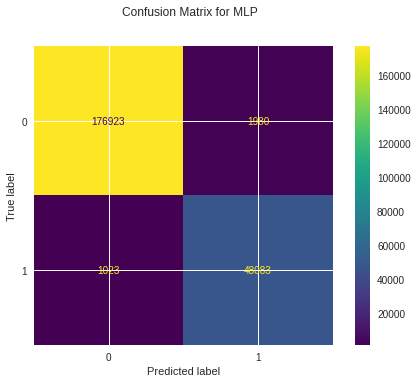

Classification report for classifier MLP:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    178903
           1       0.96      0.98      0.97     49106

    accuracy                           0.99    228009
   macro avg       0.98      0.98      0.98    228009
weighted avg       0.99      0.99      0.99    228009


ROC-AUC for classifier MLPClassifier() 
 


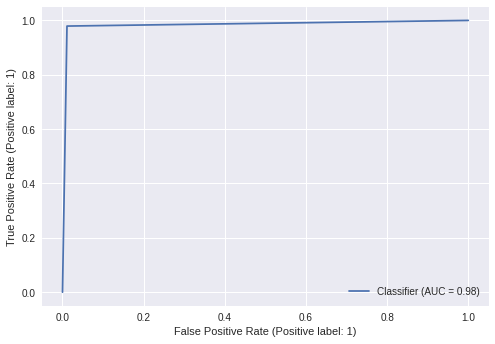

Classifier Naive Bayes took 0.020243166666666666 mins


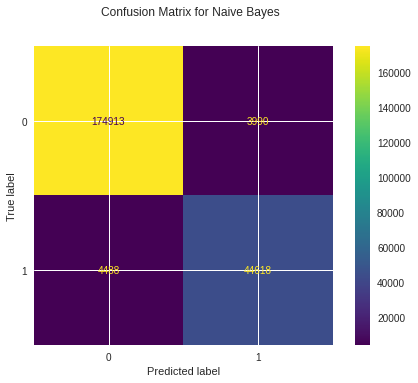

Classification report for classifier Naive Bayes:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98    178903
           1       0.92      0.91      0.91     49106

    accuracy                           0.96    228009
   macro avg       0.95      0.94      0.94    228009
weighted avg       0.96      0.96      0.96    228009


ROC-AUC for classifier GaussianNB() 
 


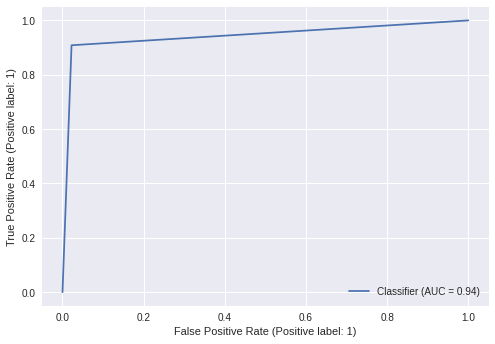

Classifier Logistic Regression took 0.27207139999999996 mins


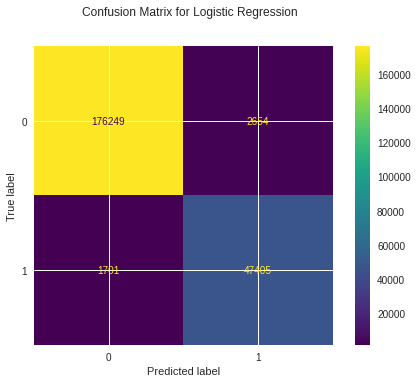

Classification report for classifier Logistic Regression:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    178903
           1       0.95      0.97      0.96     49106

    accuracy                           0.98    228009
   macro avg       0.97      0.98      0.97    228009
weighted avg       0.98      0.98      0.98    228009


ROC-AUC for classifier LogisticRegression(random_state=42) 
 


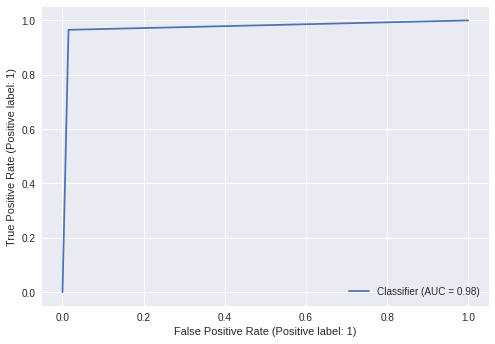

Classifier SVM took 0.8843689833333334 mins


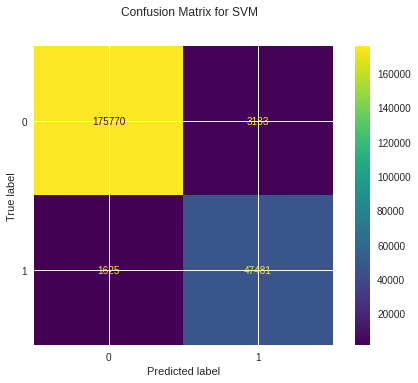

Classification report for classifier SVM:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99    178903
           1       0.94      0.97      0.95     49106

    accuracy                           0.98    228009
   macro avg       0.96      0.97      0.97    228009
weighted avg       0.98      0.98      0.98    228009


ROC-AUC for classifier LinearSVC(random_state=42, tol=1e-05) 
 


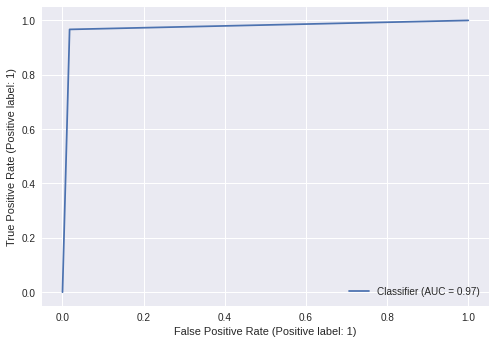

Classifier Decison Tree took 0.20500566666666667 mins


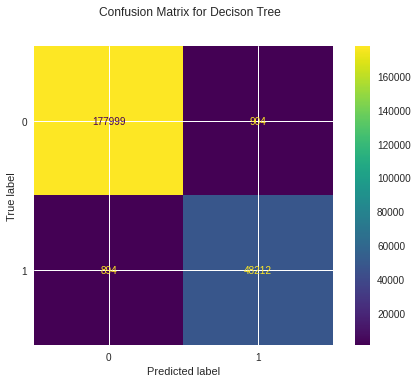

Classification report for classifier Decison Tree:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    178903
           1       0.98      0.98      0.98     49106

    accuracy                           0.99    228009
   macro avg       0.99      0.99      0.99    228009
weighted avg       0.99      0.99      0.99    228009


ROC-AUC for classifier DecisionTreeClassifier() 
 


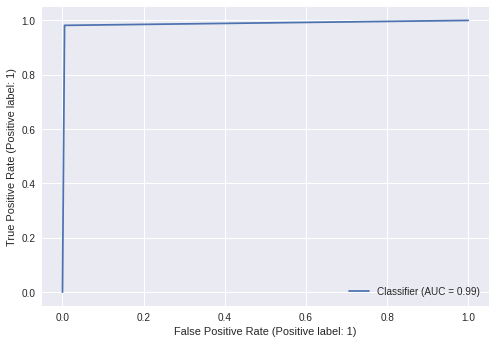

Classifier Random Forest took 2.6430320333333333 mins


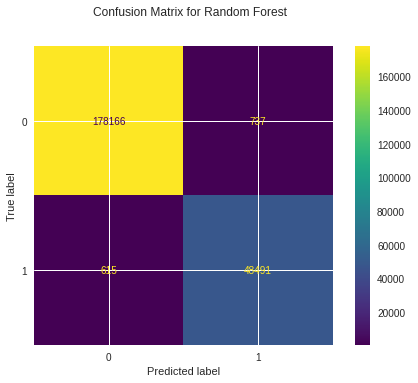

Classification report for classifier Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    178903
           1       0.99      0.99      0.99     49106

    accuracy                           0.99    228009
   macro avg       0.99      0.99      0.99    228009
weighted avg       0.99      0.99      0.99    228009


ROC-AUC for classifier RandomForestClassifier(random_state=42) 
 


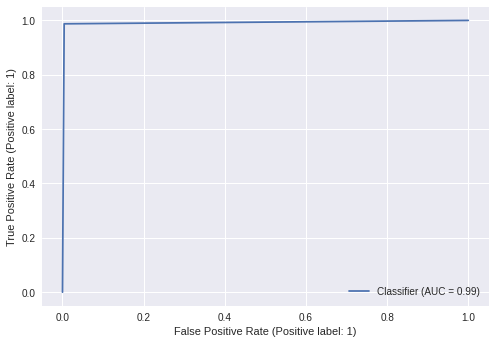

Classifier XGBoost took 2.6831109 mins


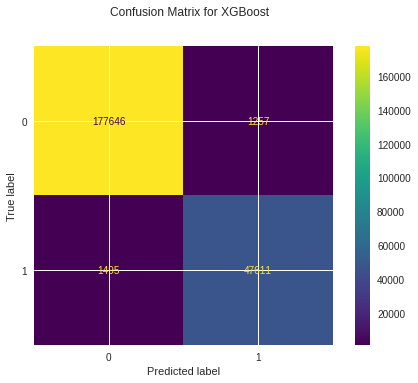

Classification report for classifier XGBoost:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    178903
           1       0.97      0.97      0.97     49106

    accuracy                           0.99    228009
   macro avg       0.98      0.98      0.98    228009
weighted avg       0.99      0.99      0.99    228009


ROC-AUC for classifier XGBClassifier(random_state=42) 
 


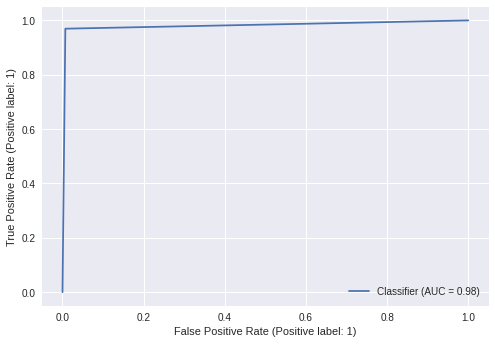

Classifier Voting Classifier took 2.645106683333333 mins


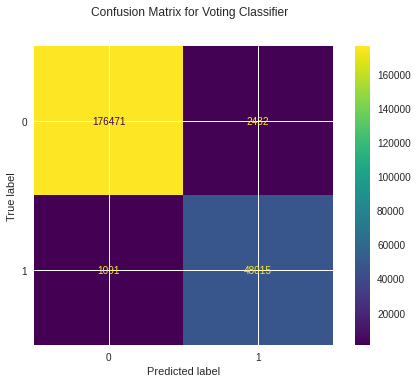

Classification report for classifier Voting Classifier:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    178903
           1       0.95      0.98      0.96     49106

    accuracy                           0.98    228009
   macro avg       0.97      0.98      0.98    228009
weighted avg       0.98      0.98      0.98    228009


ROC-AUC for classifier VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('gnb', GaussianNB())]) 
 


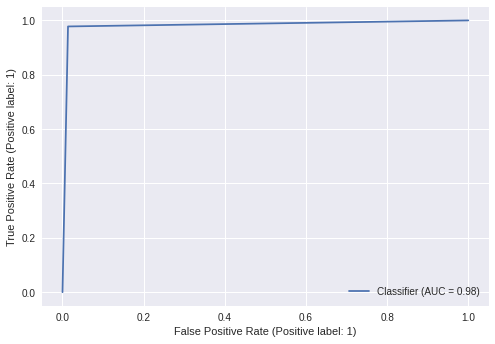

Classifier AdaBoost took 2.4589064166666663 mins


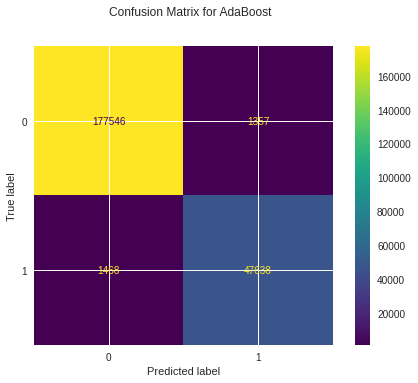

Classification report for classifier AdaBoost:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    178903
           1       0.97      0.97      0.97     49106

    accuracy                           0.99    228009
   macro avg       0.98      0.98      0.98    228009
weighted avg       0.99      0.99      0.99    228009


ROC-AUC for classifier AdaBoostClassifier() 
 


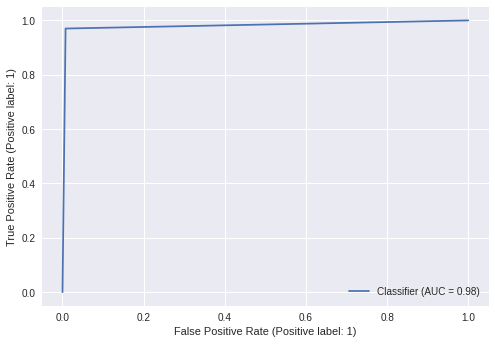

Classifier MLP took 8.17876965 mins


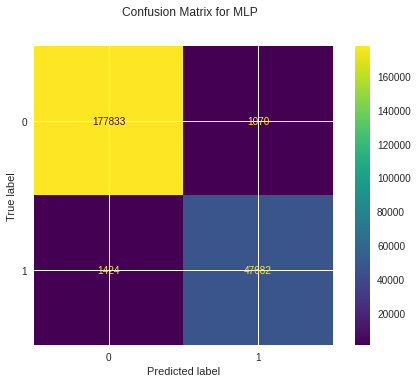

Classification report for classifier MLP:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    178903
           1       0.98      0.97      0.97     49106

    accuracy                           0.99    228009
   macro avg       0.99      0.98      0.98    228009
weighted avg       0.99      0.99      0.99    228009


ROC-AUC for classifier MLPClassifier() 
 


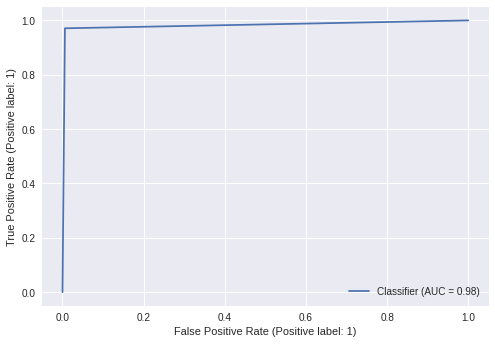

Classifier Naive Bayes took 0.010115166666666666 mins


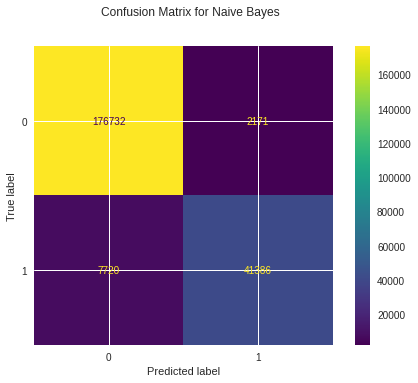

Classification report for classifier Naive Bayes:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97    178903
           1       0.95      0.84      0.89     49106

    accuracy                           0.96    228009
   macro avg       0.95      0.92      0.93    228009
weighted avg       0.96      0.96      0.96    228009


ROC-AUC for classifier GaussianNB() 
 


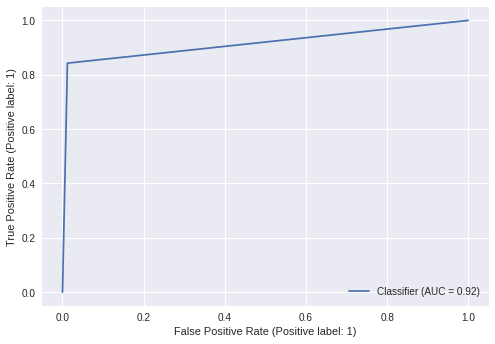

Classifier Logistic Regression took 0.26458936666666666 mins


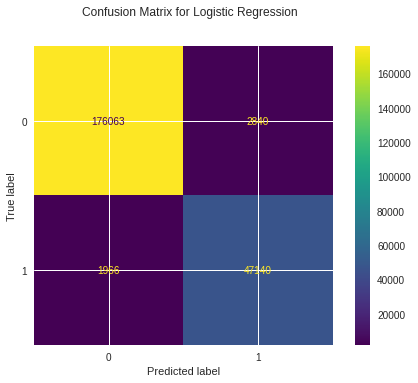

Classification report for classifier Logistic Regression:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99    178903
           1       0.94      0.96      0.95     49106

    accuracy                           0.98    228009
   macro avg       0.97      0.97      0.97    228009
weighted avg       0.98      0.98      0.98    228009


ROC-AUC for classifier LogisticRegression(random_state=42) 
 


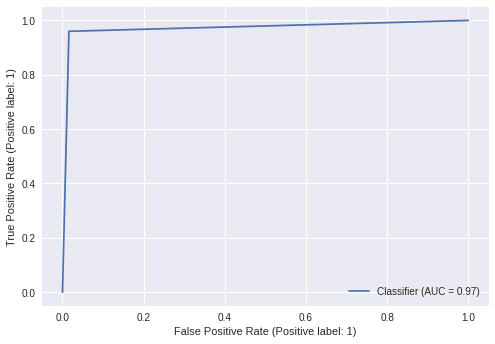

Classifier SVM took 0.5421182166666667 mins


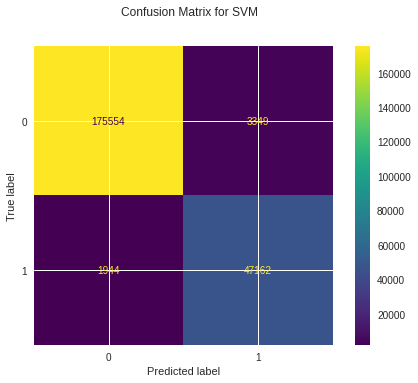

Classification report for classifier SVM:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99    178903
           1       0.93      0.96      0.95     49106

    accuracy                           0.98    228009
   macro avg       0.96      0.97      0.97    228009
weighted avg       0.98      0.98      0.98    228009


ROC-AUC for classifier LinearSVC(random_state=42, tol=1e-05) 
 


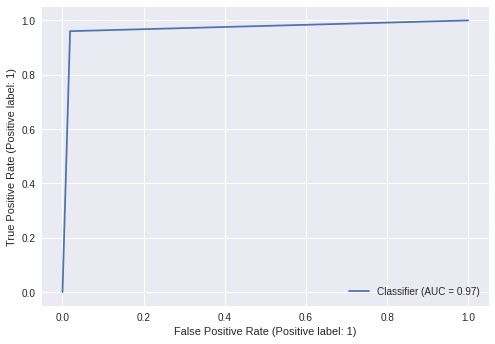

Classifier Decison Tree took 2.4527091333333333 mins


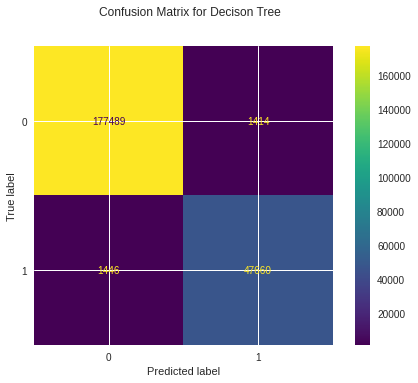

Classification report for classifier Decison Tree:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    178903
           1       0.97      0.97      0.97     49106

    accuracy                           0.99    228009
   macro avg       0.98      0.98      0.98    228009
weighted avg       0.99      0.99      0.99    228009


ROC-AUC for classifier DecisionTreeClassifier() 
 


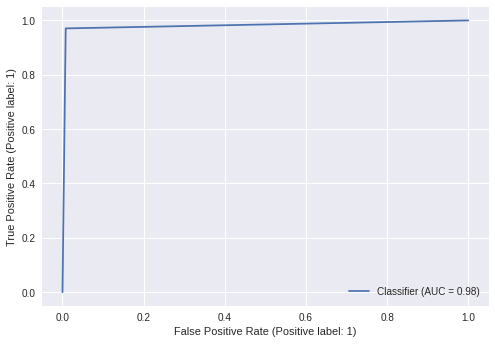

Classifier Random Forest took 19.619022066666666 mins


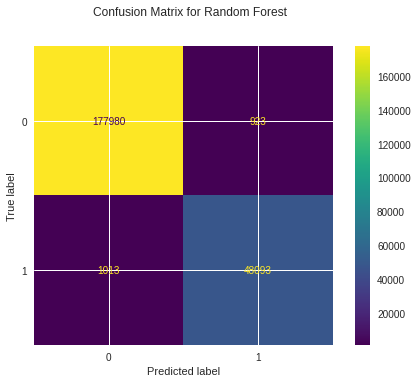

Classification report for classifier Random Forest:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    178903
           1       0.98      0.98      0.98     49106

    accuracy                           0.99    228009
   macro avg       0.99      0.99      0.99    228009
weighted avg       0.99      0.99      0.99    228009


ROC-AUC for classifier RandomForestClassifier(random_state=42) 
 


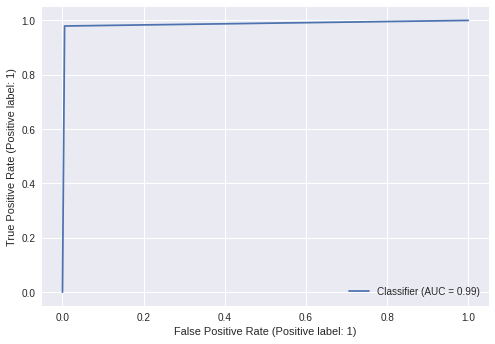

Classifier XGBoost took 4.726382183333333 mins


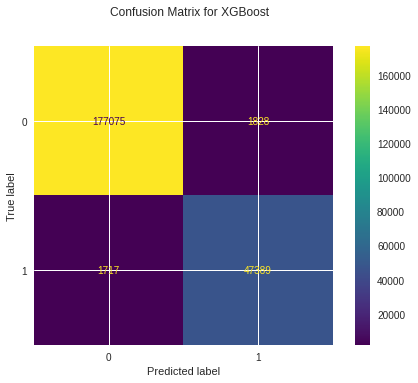

Classification report for classifier XGBoost:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    178903
           1       0.96      0.97      0.96     49106

    accuracy                           0.98    228009
   macro avg       0.98      0.98      0.98    228009
weighted avg       0.98      0.98      0.98    228009


ROC-AUC for classifier XGBClassifier(random_state=42) 
 


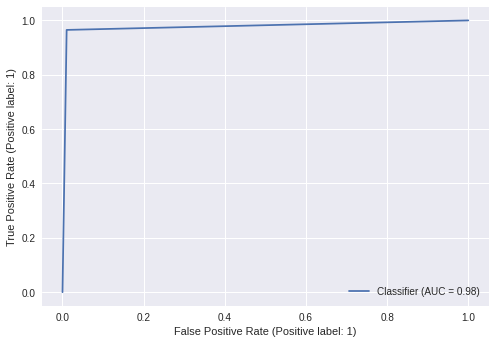

Classifier Voting Classifier took 19.320578983333334 mins


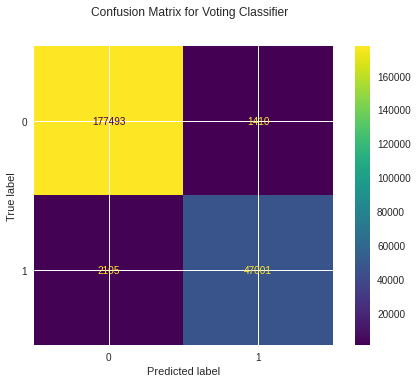

Classification report for classifier Voting Classifier:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    178903
           1       0.97      0.96      0.96     49106

    accuracy                           0.98    228009
   macro avg       0.98      0.97      0.98    228009
weighted avg       0.98      0.98      0.98    228009


ROC-AUC for classifier VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('gnb', GaussianNB())]) 
 


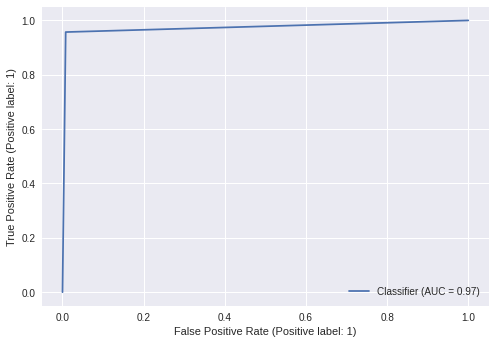

Classifier AdaBoost took 6.2509542 mins


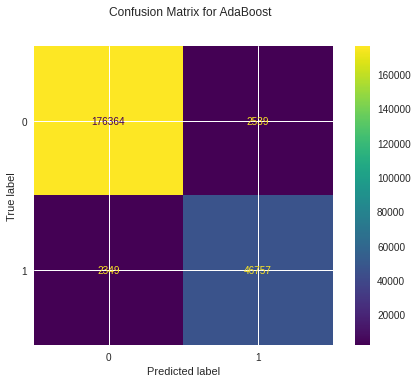

Classification report for classifier AdaBoost:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    178903
           1       0.95      0.95      0.95     49106

    accuracy                           0.98    228009
   macro avg       0.97      0.97      0.97    228009
weighted avg       0.98      0.98      0.98    228009


ROC-AUC for classifier AdaBoostClassifier() 
 


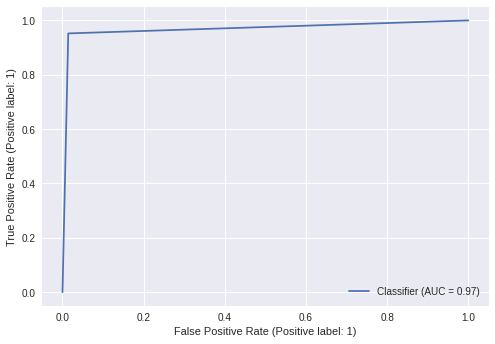

Classifier MLP took 3.51357585 mins


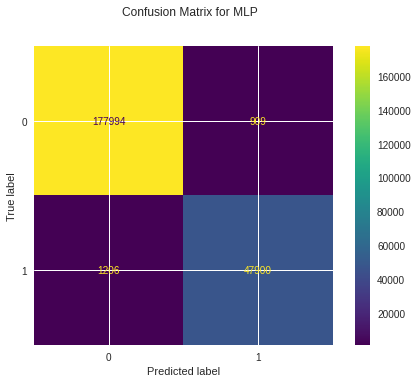

Classification report for classifier MLP:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    178903
           1       0.98      0.98      0.98     49106

    accuracy                           0.99    228009
   macro avg       0.99      0.99      0.99    228009
weighted avg       0.99      0.99      0.99    228009


ROC-AUC for classifier MLPClassifier() 
 


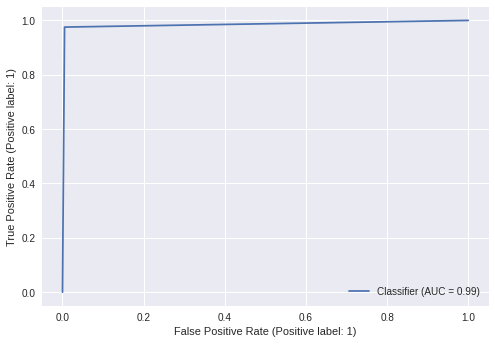

In [14]:
cols_cat = df.select_dtypes('object').columns
cols_numeric = df._get_numeric_data().columns 

def Remove_dump_values(data, cols):
    for col in cols:
        data[col] = np.where(data[col] == '-', 'None', data[col])
    return data

cols = df.columns
data_bin = Remove_dump_values(df, cols)
df,y = encoding(df)
cols_numeric = list(cols_numeric)
cols_numeric.remove('Label')
df[cols_numeric] = df[cols_numeric].astype('float') 
print('Value counts ',y.value_counts())
new_datasets = create_dataset(df,y,'UNSW-NB15')
pca(df,50)
pca_data = PCA(n_components=40).fit_transform(df.values,y)
pca_data = pd.DataFrame(data= pca_data)
new_datasets.append( (pca_data,y ))
print('modified pca data shape: ',pca_data.shape)

logger = open('log_unsw.csv','a')
print("log_id","ConfusionMatrix","RunTime (mins)",sep=',',flush=True,file=logger)


(run_times,confusion_matrices,roc_aucs,cf_figures) = log_metrics(new_datasets,logger)
# imbalanced_classification(new_datasets,logger)

In [16]:
logger.close()

log = pd.read_csv('log.csv')
log[['tp','fn','fp','tn']]=log['ConfusionMatrix'].str.split('\s+', expand = True)
log[['tp','fn','fp','tn']] = log[['tp','fn','fp','tn']].apply(pd.to_numeric,errors='coerce')
log['accuracy']=log.apply(lambda row: (row.tp+row.tn)/(row.tp+row.fp+row.tn+row.fn), axis=1)
log['precision']=log.apply(lambda row: (row.tp)/(row.tp+row.fp), axis=1)
log['recall']=log.apply(lambda row: (row.tp)/(row.tp+row.fn), axis=1)
log['f1score']=log.apply(lambda row: (row.precision*row.recall*2)/(row.precision+row.recall), axis=1)
log.drop(['tp', 'fn','fp','tn'], axis = 1,inplace=True)


# logging the index of dataset+model pair highest metrics
print(log.query('precision==precision.max()'))
print(log.query('recall==recall.max()'))
print(log.query('f1score==f1score.max()'))
print(log.query('accuracy==accuracy.max()'))

    log_id           ConfusionMatrix  RunTime (mins)  accuracy  precision  \
12      12  82670    86     61 57727        0.111021  0.998954   0.999263   

      recall   f1score  
12  0.998961  0.999112  
    log_id           ConfusionMatrix  RunTime (mins)  accuracy  precision  \
23      23  82738    18    177 57611        1.723364  0.998613   0.997865   

      recall   f1score  
23  0.999782  0.998823  
    log_id           ConfusionMatrix  RunTime (mins)  accuracy  precision  \
13      13  82713    43     82 57706        1.460243  0.999111    0.99901   

     recall   f1score  
13  0.99948  0.999245  
    log_id           ConfusionMatrix  RunTime (mins)  accuracy  precision  \
13      13  82713    43     82 57706        1.460243  0.999111    0.99901   

     recall   f1score  
13  0.99948  0.999245  
